In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np

In [2]:
import re
import tweepy
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from IPython.display import display
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from operator import itemgetter

In [3]:
stop_nltk = stopwords.words("english")
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Twittter App Credentials Generated from Twitter Website

In [4]:
consumer_key = ""
consumer_secret = ""
access_token = "-"
access_token_secret = ""

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [6]:
def get_tweet_ids(keyword,period,startDate,endDate,maxTweets):
    
    '''
    Function to scrape tweet ids for a given hashtag using snscrape
    '''
    f = os.system('snscrape --max-results '+str(maxTweets)+' twitter-hashtag '+'"'+keyword+' since:'+startDate+' until:'+endDate+'"'+' >fetched_tweet_ids_'+period+'_#'+keyword+'.txt')
    if f==0:
        print(f"Successfully fetched {maxTweets} tweet ids for #{keyword}")

In [7]:
def fetch_tw(ids,keyword,period):
    
    '''
    Function to extract tweet attributes - id, text, date, hashtags, usermentions
    '''
    list_of_tw_status = api.statuses_lookup(id_=ids,tweet_mode="extended") #ids batch size limited to 100
    #time.sleep(5)
    empty_data = pd.DataFrame()
    
    for status in list_of_tw_status:
        
        if status.lang=='en': #getting only tweets in english
        
            #if str(status.created_at).split(' ')[0]>'2019-12-17':
                
            try:
                hashtags = list(map(itemgetter('text'),status.entities['hashtags'])) 
            except:
                hashtags=None
            try:
                user_mentions=status.entities['user_mentions'][0]['screen_name']
            except:
                user_mentions=None
                    
            tweet_elem = {"id":status.id,
                          "date":status.created_at,
                          "tweet":status.full_text,
                          "hashtags":str(hashtags).strip('[]'),
                          "usermentions":user_mentions}
            
        else:
            continue
        
        empty_data = empty_data.append(tweet_elem,ignore_index=True)
            
    empty_data.to_csv("fetched_tweets_"+period+'_#'+keyword+".csv", mode="a",index=False)

In [8]:
def get_tweets(keyword,period):
    
    '''
    Function to get tweet data using tweet ids
    '''
 
    #Extracting ids from the tweet urls
    tweet_url = pd.read_csv("fetched_tweet_ids_"+period+"_#"+keyword+".txt", index_col= None, header = None, names = ["links"])
    af = lambda x: x["links"].split("/")[-1]
    tweet_url['id'] = tweet_url.apply(af, axis=1)
    ids = tweet_url['id'].tolist()
    
    # Processing the ids in batches
    total_count = len(ids)
    chunks = (total_count - 1) // 50 + 1
    for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch,keyword,period)
        print(f'Batch {i+1} processed successfully...')

In [9]:
def get_processed_tweets(keywords,period,startDate,endDate,maxTweets):

    '''
    Function to get processed tweets
    '''
    
    # Importing dependent functions
    
    for keyword in keywords:
        
        get_tweet_ids(keyword,period,startDate,endDate,maxTweets)

        get_tweets(keyword,period)
        
    # Merging all records from csv files of different hashtags
    
    tweets = []
    
    for keyword in keywords:
    
        df = pd.read_csv('fetched_tweets_'+period+'_#'+keyword+'.csv',index_col=None,header=0)
        tweets.append(df)
        
    tweet_data = pd.concat(tweets,axis=0,ignore_index=True)
    
    tweet_data.columns = ['Date_time','Hashtags','ID','Tweet_text','Usermentions'] # Naming columns

    # Removing repetitive headers
    indices = tweet_data[tweet_data['Tweet_text']=='tweet'].index
    tweet_data.drop(indices,inplace=True)
    
    # Removing duplicate records keeping the first one
    tweet_data.drop_duplicates("ID",inplace=True)

    # Converting to datetime object
    tweet_data['Date'] = tweet_data['Date_time'].str.split(" ",expand=True)[0]
    tweet_data = tweet_data.drop(['Date_time'],axis=1)
    tweet_data['Date'] = pd.to_datetime(tweet_data['Date'],infer_datetime_format=True)
    
    # Removing rows that fall outside of the date range
    tweet_data = tweet_data[(tweet_data['Date']>=startDate) & (tweet_data['Date']<=endDate)]
    
    # Converting IDs to integers
    tweet_data['ID'] = [int(float(i)) for i in tweet_data['ID'].to_list()] # Conversion from scientific to integer notation

    # Rearranging columns
    tweet_data = tweet_data[['ID','Date','Tweet_text','Hashtags','Usermentions']]
    
    # Sorting rows based on date
    tweet_data.sort_values(ascending=False, by="Date",inplace=True)

    return tweet_data

In [10]:
# List of hashtags to search (equivalent to 'OR')
keywords = ['bajaj','@bajaj','pulsar','dominar','ct100','@bajaj_ltd','@Bajajauto','@my_pulsar','bajaj-auto','bajajauto']
periods = ['precovid','postcovid']
dates = ['2019-07-01','2020-02-29','2020-03-01',str(datetime.date.today())]
maxTweets = 100000

In [11]:
pre_covid_tweets = get_processed_tweets(keywords,periods[0],dates[0],dates[1],maxTweets)

Successfully fetched 100000 tweet ids for #bajaj
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Batch 24 processed successfully...
Batch 25 processed successfully...
Batch 26 processed successfully...
Batch 27 processed successfully...
Batch 28 proces

Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Batch 24 processed successfully...
Batch 25 processed successfully...
Batch 26 processed successfully...
Batch 27 processed successfully...
Batch 28 processed successfully...
Batch 29 processed successfully...
Batch 30 processed successfully...
Batch 31 processed successfully...
Batch 32 processed successfully...
Batch 33 processed successfully...
Batch 34 processed successfully...
Batch 35 processed successfully...
Batch 36 processed successfully...
Batch 37 processed successfully...
Batch 38 processed successfully...
Batch 39 processed successfully...
Batch 40 processed successfully...
Batch 41 processed successfully...
Batch 42 processed successfully...
Batch 43 processed s

Batch 59 processed successfully...
Batch 60 processed successfully...
Batch 61 processed successfully...
Batch 62 processed successfully...
Batch 63 processed successfully...
Batch 64 processed successfully...
Batch 65 processed successfully...
Batch 66 processed successfully...
Batch 67 processed successfully...
Batch 68 processed successfully...
Batch 69 processed successfully...
Batch 70 processed successfully...
Batch 71 processed successfully...
Batch 72 processed successfully...
Batch 73 processed successfully...
Batch 74 processed successfully...
Batch 75 processed successfully...
Batch 76 processed successfully...
Batch 77 processed successfully...
Batch 78 processed successfully...
Batch 79 processed successfully...
Batch 80 processed successfully...
Batch 81 processed successfully...
Batch 82 processed successfully...
Batch 83 processed successfully...
Batch 84 processed successfully...
Batch 85 processed successfully...
Batch 86 processed successfully...
Batch 87 processed s

In [12]:
post_covid_tweets = get_processed_tweets(keywords,periods[1],dates[2],dates[3],maxTweets)

Successfully fetched 100000 tweet ids for #bajaj
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Batch 24 processed successfully...
Batch 25 processed successfully...
Batch 26 processed successfully...
Batch 27 processed successfully...
Batch 28 proces

Batch 41 processed successfully...
Batch 42 processed successfully...
Batch 43 processed successfully...
Batch 44 processed successfully...
Batch 45 processed successfully...
Batch 46 processed successfully...
Batch 47 processed successfully...
Batch 48 processed successfully...
Batch 49 processed successfully...
Batch 50 processed successfully...
Batch 51 processed successfully...
Batch 52 processed successfully...
Batch 53 processed successfully...
Batch 54 processed successfully...
Batch 55 processed successfully...
Batch 56 processed successfully...
Batch 57 processed successfully...
Batch 58 processed successfully...
Batch 59 processed successfully...
Batch 60 processed successfully...
Batch 61 processed successfully...
Batch 62 processed successfully...
Batch 63 processed successfully...
Batch 64 processed successfully...
Batch 65 processed successfully...
Batch 66 processed successfully...
Batch 67 processed successfully...
Batch 68 processed successfully...
Batch 69 processed s

Batch 28 processed successfully...
Batch 29 processed successfully...
Successfully fetched 100000 tweet ids for #@my_pulsar
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Successfully fetched 100000 tweet ids for #bajaj-auto
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...


Batch 218 processed successfully...
Batch 219 processed successfully...
Batch 220 processed successfully...
Batch 221 processed successfully...
Batch 222 processed successfully...
Batch 223 processed successfully...
Batch 224 processed successfully...
Batch 225 processed successfully...
Batch 226 processed successfully...
Batch 227 processed successfully...
Batch 228 processed successfully...
Batch 229 processed successfully...
Batch 230 processed successfully...
Batch 231 processed successfully...
Batch 232 processed successfully...
Successfully fetched 100000 tweet ids for #bajajauto
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully

In [13]:
post_covid_tweets.count()

ID              24818
Date            24818
Tweet_text      24818
Hashtags        13778
Usermentions    12729
dtype: int64

In [14]:
pre_covid_tweets.count()

ID              15672
Date            15672
Tweet_text      15672
Hashtags         9197
Usermentions     7648
dtype: int64

In [15]:
post_covid_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
9353,1340268501538205696,2020-12-19,@bajaj_ltd services very bad experiences I ha...,NaN,bajaj_ltd
21,1340284273274757120,2020-12-19,#bajaj v12 is the worst bike bajaj had looted ...,'bajaj',NaN
17129,1340341135596609536,2020-12-19,#BAJAJ_AUTO - BAJAJ ABOVE 3380 CAN BREAKOUT - ...,'BAJAJ_AUTO',NaN
6563,1340106550141136896,2020-12-19,15% Off #Pulsar #APX V2 #Vaporizer\n @ https:/...,"'Pulsar', 'APX', 'Vaporizer', 'Vape', 'Dablife...",NaN
9338,1340206317907161088,2020-12-19,Dear @sanjivrbajaj @bajaj_ltd We searched for ...,NaN,sanjivrbajaj
...,...,...,...,...,...
8856,1234222082260635648,2020-03-01,23:00 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN
8857,1234228124126240768,2020-03-01,One of three variants of this Pulsar watch #wo...,"'wotd', 'watchoftheday', 'watchesofinstagram',...",NaN
9247,1233960925993943040,2020-03-01,#Appuppanthadi aka #milkweed #fluff falls on #...,"'Appuppanthadi', 'milkweed', 'fluff', 'Domi', ...",NaN
9266,1233954365599125504,2020-03-01,The season for #Umbadiyu is almost over! I rod...,"'Umbadiyu', 'Dominar'",NaN


In [16]:
pre_covid_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
1,1233303197277675520,2020-02-28,Reversal Buy #BAJAJ-AUTO 2901.15 28/02/20 1:30...,"'BAJAJ', 'NimblrTA', 'Amibroker'",NaN
22,1233388534838390784,2020-02-28,#Bajaj Finance strict SL 4300 buy for 5500+ le...,'Bajaj',NaN
24,1233357960279134208,2020-02-28,"Ladies and gentlemen, #Bajaj is all set to lau...","'Bajaj', 'Dominar250', 'bajaj'",NaN
4163,1233501153851314176,2020-02-28,23:13 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN
28,1233217757942046720,2020-02-28,"The Strongest Brands ranked on Trust, Online P...","'intraday', 'nifty50', 'mukulagrawal', 'techni...",NaN
...,...,...,...,...,...
16788,1145560845218267136,2019-07-01,Benchmark indices are trading higher today on ...,"'Sensex', 'Nifty'",NaN
16786,1145613778920198144,2019-07-01,*Bajaj Auto June'19 Sales marginally below exp...,'news',NaN
16783,1145575864597450752,2019-07-01,June #Auto Sales\n\nBajaj Auto \nTotal Sales f...,'Auto',NaN
16729,1145659650701963264,2019-07-01,Sensex soars 292 points on easing trade war co...,NaN,NaN


In [17]:
pre_covid_tweets.shape

(15672, 5)

In [18]:
post_covid_tweets.shape

(24818, 5)

In [19]:
pre_covid_tweets.to_csv(r'pre_covid_tweets.csv', index = False)
post_covid_tweets.to_csv(r'post_covid_tweets.csv', index = False)

In [21]:
pre_covid_tweets["Usermentions"].value_counts()

bajaj_ltd          1948
Bajajauto           508
my_pulsar           161
eBay                112
BAJAJ                76
                   ... 
sunil47949870         1
IamcitizenIndia       1
FinMinIndia           1
Kotresh92162508       1
rohitmishraindi       1
Name: Usermentions, Length: 2247, dtype: int64

In [22]:
pre_covid_tweets["Usermentions"].isnull().value_counts()/pre_covid_tweets.shape[0]

True     0.511996
False    0.488004
Name: Usermentions, dtype: float64

In [23]:
pre_covid_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15672 entries, 1 to 16784
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID            15672 non-null  int64         
 1   Date          15672 non-null  datetime64[ns]
 2   Tweet_text    15672 non-null  object        
 3   Hashtags      9197 non-null   object        
 4   Usermentions  7648 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 734.6+ KB


In [24]:
post_covid_tweets["Usermentions"].value_counts()/post_covid_tweets.shape[0]*100

bajaj_ltd         10.125715
Bajajauto          1.494883
TheDeshBhakt       1.470707
CNBCTV18News       0.826013
Suhelseth          0.809896
                    ...    
DrivesparkKa       0.004029
SujathaKSNS        0.004029
arunbothra         0.004029
Anandi07135701     0.004029
sambrani           0.004029
Name: Usermentions, Length: 3290, dtype: float64

## Stopping NLTK Keywords

In [25]:
stop_updated = stop_nltk + ["bajaj","@bajaj","bike","motorcycle","biker","bikes","motorcycles",
                            "pulsar","@pulsar","ct100","rider","ride","video","customkeychain","keychain",
                            "gelkeychain","bajaj_ltd","Bajajauto","my_pulsar","two","wheeler","Two Wheeer","bajaj-auto",
                            "Platina","Avenger","Avenger-Street","Chetak","PulasrNS","Dominar"]
stemmer_s = SnowballStemmer("english")

## Clean Function

In [26]:
def clean_tweet(tweet):
    
    '''
    Function to clean tweet text
    '''
    # Removing links,special characters, etc. using regular expressions
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(#[A-Za-z0-9]+)", " ",tweet)
    # Removing words like rt and search string
    drop_list = ["Heromotocorp ","Hero Motocorp","bike","scooters","biker",
                "bikes","motorcycles","hero","Hero","infy","coalindia","PMO"]
    tokens = text.lower().strip().split()
    tokens_clean = [term for term in tokens if term not in drop_list and len(term)>2]
    
    stemmed = [stemmer_s.stem(term) for term in tokens_clean \
               if term not in stop_updated and \
               len(term) > 2] 
    res = " ".join(stemmed)
    return res

In [27]:
pre_covid_tweets['clean_tweets'] =pre_covid_tweets.Tweet_text.apply(clean_tweet)
pre_covid_tweets[['Date','Tweet_text','clean_tweets']]

,Date,Tweet_text,clean_tweets
1,2020-02-28,Reversal Buy #BAJAJ-AUTO 2901.15 28/02/20 1:30...,revers buy auto 2901 2851 2971 nimblrta amibro...
22,2020-02-28,#Bajaj Finance strict SL 4300 buy for 5500+ le...,financ strict 4300 buy 5500 level
24,2020-02-28,"Ladies and gentlemen, #Bajaj is all set to lau...",ladi gentlemen set launch smaller dominar250 i...
4163,2020-02-28,23:13 Anomaly breathing blood. Frequency/hour ...,anomali breath blood frequenc hour 124 31811 p...
28,2020-02-28,"The Strongest Brands ranked on Trust, Online P...",strongest brand rank trust onlin prefer brand ...
...,...,...,...
16788,2019-07-01,Benchmark indices are trading higher today on ...,benchmark indic trade higher today strong glob...
16786,2019-07-01,*Bajaj Auto June'19 Sales marginally below exp...,auto june sale margin expect total sale came 4...
16783,2019-07-01,June #Auto Sales\n\nBajaj Auto \nTotal Sales f...,june auto sale auto total sale flat unit domes...
16729,2019-07-01,Sensex soars 292 points on easing trade war co...,sensex soar 292 point eas trade war concern ta...


In [28]:
pre_covid_tweets.head(5)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
1,1233303197277675520,2020-02-28,Reversal Buy #BAJAJ-AUTO 2901.15 28/02/20 1:30...,"'BAJAJ', 'NimblrTA', 'Amibroker'",NaN,revers buy auto 2901 2851 2971 nimblrta amibro...
22,1233388534838390784,2020-02-28,#Bajaj Finance strict SL 4300 buy for 5500+ le...,'Bajaj',NaN,financ strict 4300 buy 5500 level
24,1233357960279134208,2020-02-28,"Ladies and gentlemen, #Bajaj is all set to lau...","'Bajaj', 'Dominar250', 'bajaj'",NaN,ladi gentlemen set launch smaller dominar250 i...
4163,1233501153851314176,2020-02-28,23:13 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN,anomali breath blood frequenc hour 124 31811 p...
28,1233217757942046720,2020-02-28,"The Strongest Brands ranked on Trust, Online P...","'intraday', 'nifty50', 'mukulagrawal', 'techni...",NaN,strongest brand rank trust onlin prefer brand ...


In [29]:
pre_covid_tweets.shape

(15672, 6)

In [30]:
post_covid_tweets['clean_tweets']=post_covid_tweets.Tweet_text.apply(clean_tweet)

In [31]:
post_covid_tweets.head(5)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
9353,1340268501538205696,2020-12-19,@bajaj_ltd services very bad experiences I ha...,NaN,bajaj_ltd,ltd servic bad experi got meera road suryoday ...
21,1340284273274757120,2020-12-19,#bajaj v12 is the worst bike bajaj had looted ...,'bajaj',NaN,v12 worst loot money face troubl want answer p...
17129,1340341135596609536,2020-12-19,#BAJAJ_AUTO - BAJAJ ABOVE 3380 CAN BREAKOUT - ...,'BAJAJ_AUTO',NaN,auto 3380 breakout tradingview
6563,1340106550141136896,2020-12-19,15% Off #Pulsar #APX V2 #Vaporizer\n @ https:/...,"'Pulsar', 'APX', 'Vaporizer', 'Vape', 'Dablife...",NaN,apx vapor use code holiday15 vape dablif hight...
9338,1340206317907161088,2020-12-19,Dear @sanjivrbajaj @bajaj_ltd We searched for ...,NaN,sanjivrbajaj,dear ltd search rahul sir amp rajiv twitter ha...


In [32]:
all_tweets = pd.concat([pre_covid_tweets,post_covid_tweets])
all_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
1,1233303197277675520,2020-02-28,Reversal Buy #BAJAJ-AUTO 2901.15 28/02/20 1:30...,"'BAJAJ', 'NimblrTA', 'Amibroker'",NaN,revers buy auto 2901 2851 2971 nimblrta amibro...
22,1233388534838390784,2020-02-28,#Bajaj Finance strict SL 4300 buy for 5500+ le...,'Bajaj',NaN,financ strict 4300 buy 5500 level
24,1233357960279134208,2020-02-28,"Ladies and gentlemen, #Bajaj is all set to lau...","'Bajaj', 'Dominar250', 'bajaj'",NaN,ladi gentlemen set launch smaller dominar250 i...
4163,1233501153851314176,2020-02-28,23:13 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN,anomali breath blood frequenc hour 124 31811 p...
28,1233217757942046720,2020-02-28,"The Strongest Brands ranked on Trust, Online P...","'intraday', 'nifty50', 'mukulagrawal', 'techni...",NaN,strongest brand rank trust onlin prefer brand ...
...,...,...,...,...,...,...
8856,1234222082260635648,2020-03-01,23:00 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN,anomali breath blood frequenc hour 31859 pulsa...
8857,1234228124126240768,2020-03-01,One of three variants of this Pulsar watch #wo...,"'wotd', 'watchoftheday', 'watchesofinstagram',...",NaN,one three variant watch wotd watchoftheday wat...
9247,1233960925993943040,2020-03-01,#Appuppanthadi aka #milkweed #fluff falls on #...,"'Appuppanthadi', 'milkweed', 'fluff', 'Domi', ...",NaN,appuppanthadi aka milkwe fluff fall domi domin...
9266,1233954365599125504,2020-03-01,The season for #Umbadiyu is almost over! I rod...,"'Umbadiyu', 'Dominar'",NaN,season umbadiyu almost rode dominar mumbai val...


In [33]:
pre_covid_comb_tweets=" ".join(pre_covid_tweets.clean_tweets.values)
pre_covid_comb_tweets[:300]

'revers buy auto 2901 2851 2971 nimblrta amibrok access live mobil financ strict 4300 buy 5500 level ladi gentlemen set launch smaller dominar250 india soon everyth need know anomali breath blood frequenc hour 124 31811 pulsarman strongest brand rank trust onlin prefer brand recal brand promis produc'

In [34]:
post_covid_comb_tweets=" ".join(post_covid_tweets.clean_tweets.values)

In [35]:
post_covid_comb_tweets[:500]

'ltd servic bad experi got meera road suryoday servic charg expens proper servic provid ego much employe day kept servic provid good servic bought big mistak v12 worst loot money face troubl want answer pay failur vehicl auto 3380 breakout tradingview apx vapor use code holiday15 vape dablif hightim vapefam cannabi mmj cannabiscultur dab dab 710life 420life ecig vapor vape marijuana cbd mmj legal dear ltd search rahul sir amp rajiv twitter handl find friend scientist amp invent 200 rang technolog'

In [36]:
comb_tweets=pre_covid_comb_tweets+post_covid_comb_tweets
comb_tweets[:500]

'revers buy auto 2901 2851 2971 nimblrta amibrok access live mobil financ strict 4300 buy 5500 level ladi gentlemen set launch smaller dominar250 india soon everyth need know anomali breath blood frequenc hour 124 31811 pulsarman strongest brand rank trust onlin prefer brand recal brand promis product innov intraday nifty50 mukulagraw technicalanalysi stockmarket india tatamotor relianc tcs mahindraandmahindra sbi googl hdfcbank facebook ipl visit swgr industri suppli ebay shop brows fantast rang'

In [37]:
comb_tweets=" ".join((pre_covid_comb_tweets,post_covid_comb_tweets))
comb_tweets[:500]

'revers buy auto 2901 2851 2971 nimblrta amibrok access live mobil financ strict 4300 buy 5500 level ladi gentlemen set launch smaller dominar250 india soon everyth need know anomali breath blood frequenc hour 124 31811 pulsarman strongest brand rank trust onlin prefer brand recal brand promis product innov intraday nifty50 mukulagraw technicalanalysi stockmarket india tatamotor relianc tcs mahindraandmahindra sbi googl hdfcbank facebook ipl visit swgr industri suppli ebay shop brows fantast rang'

## Generating Final Data Sets

In [38]:
'''
FINAL DATASETS

pre_covid_tweets
post_covid_tweets
all_tweets


'''
# Exporting the processed data to csv files

pre_covid_tweets.to_csv(r'pre_covid_tweets.csv', index = False)
post_covid_tweets.to_csv(r'post_covid_tweets.csv', index = False)

all_tweets.to_csv(r'all_tweets.csv', index = False)

In [39]:
all_tweets = pd.concat([pre_covid_tweets,post_covid_tweets])
all_tweets.head(5)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
1,1233303197277675520,2020-02-28,Reversal Buy #BAJAJ-AUTO 2901.15 28/02/20 1:30...,"'BAJAJ', 'NimblrTA', 'Amibroker'",NaN,revers buy auto 2901 2851 2971 nimblrta amibro...
22,1233388534838390784,2020-02-28,#Bajaj Finance strict SL 4300 buy for 5500+ le...,'Bajaj',NaN,financ strict 4300 buy 5500 level
24,1233357960279134208,2020-02-28,"Ladies and gentlemen, #Bajaj is all set to lau...","'Bajaj', 'Dominar250', 'bajaj'",NaN,ladi gentlemen set launch smaller dominar250 i...
4163,1233501153851314176,2020-02-28,23:13 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN,anomali breath blood frequenc hour 124 31811 p...
28,1233217757942046720,2020-02-28,"The Strongest Brands ranked on Trust, Online P...","'intraday', 'nifty50', 'mukulagrawal', 'techni...",NaN,strongest brand rank trust onlin prefer brand ...


In [40]:
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

# EXPLORATORY DATA ANALYSIS

In [45]:
def get_wordcloud(df):
    
    comb_tweets = " ".join(df['clean_tweets'].values)
    
    wordcloud = WordCloud(width=800,height=800,
                          stopwords=stop_updated,
                          background_color='white',
                          max_words=100,
                          normalize_plurals=True).generate_from_text(comb_tweets)
    
    return wordcloud


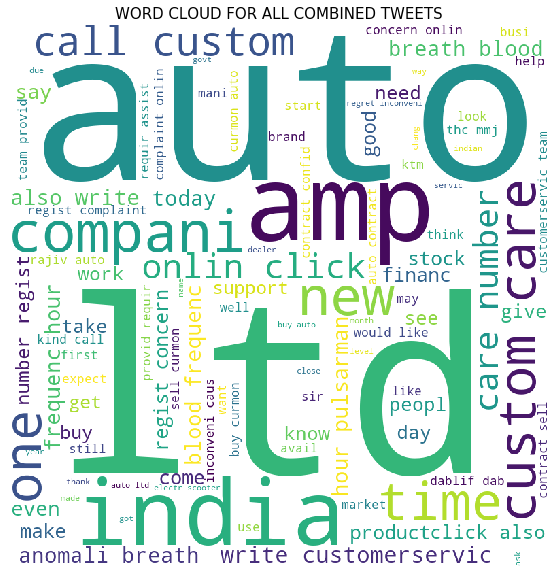

In [46]:
clouds = get_wordcloud(all_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR ALL COMBINED TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

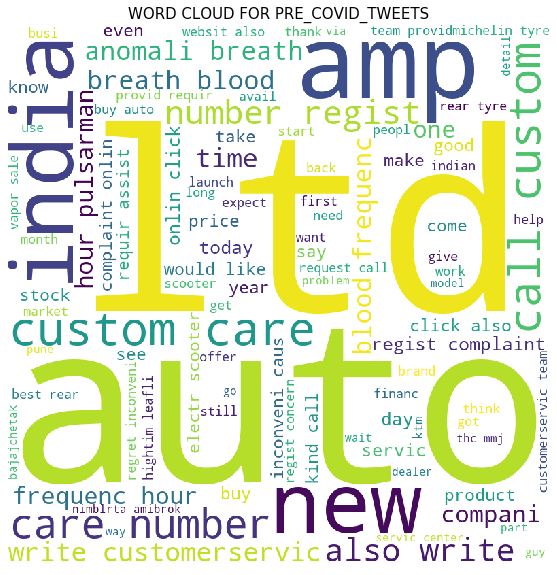

In [47]:
clouds = get_wordcloud(pre_covid_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR PRE_COVID_TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

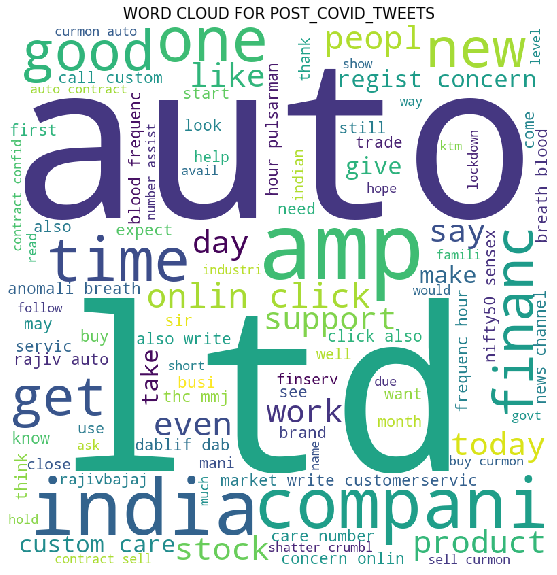

In [48]:
clouds = get_wordcloud(post_covid_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR POST_COVID_TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

## Frequency Distribution Function

In [49]:
def get_freqdist(df):
    comb_freqdist=" ".join(df['clean_tweets'].values)
    all_terms= word_tokenize(comb_freqdist)
    fdist = FreqDist([x for x in all_terms if x not in stop_updated])
    df_dist = pd.DataFrame(fdist.items(), columns = ["words","freq"])
    df_dist.sort_values(ascending=False, by="freq",inplace=True)
    
    
    return df_dist

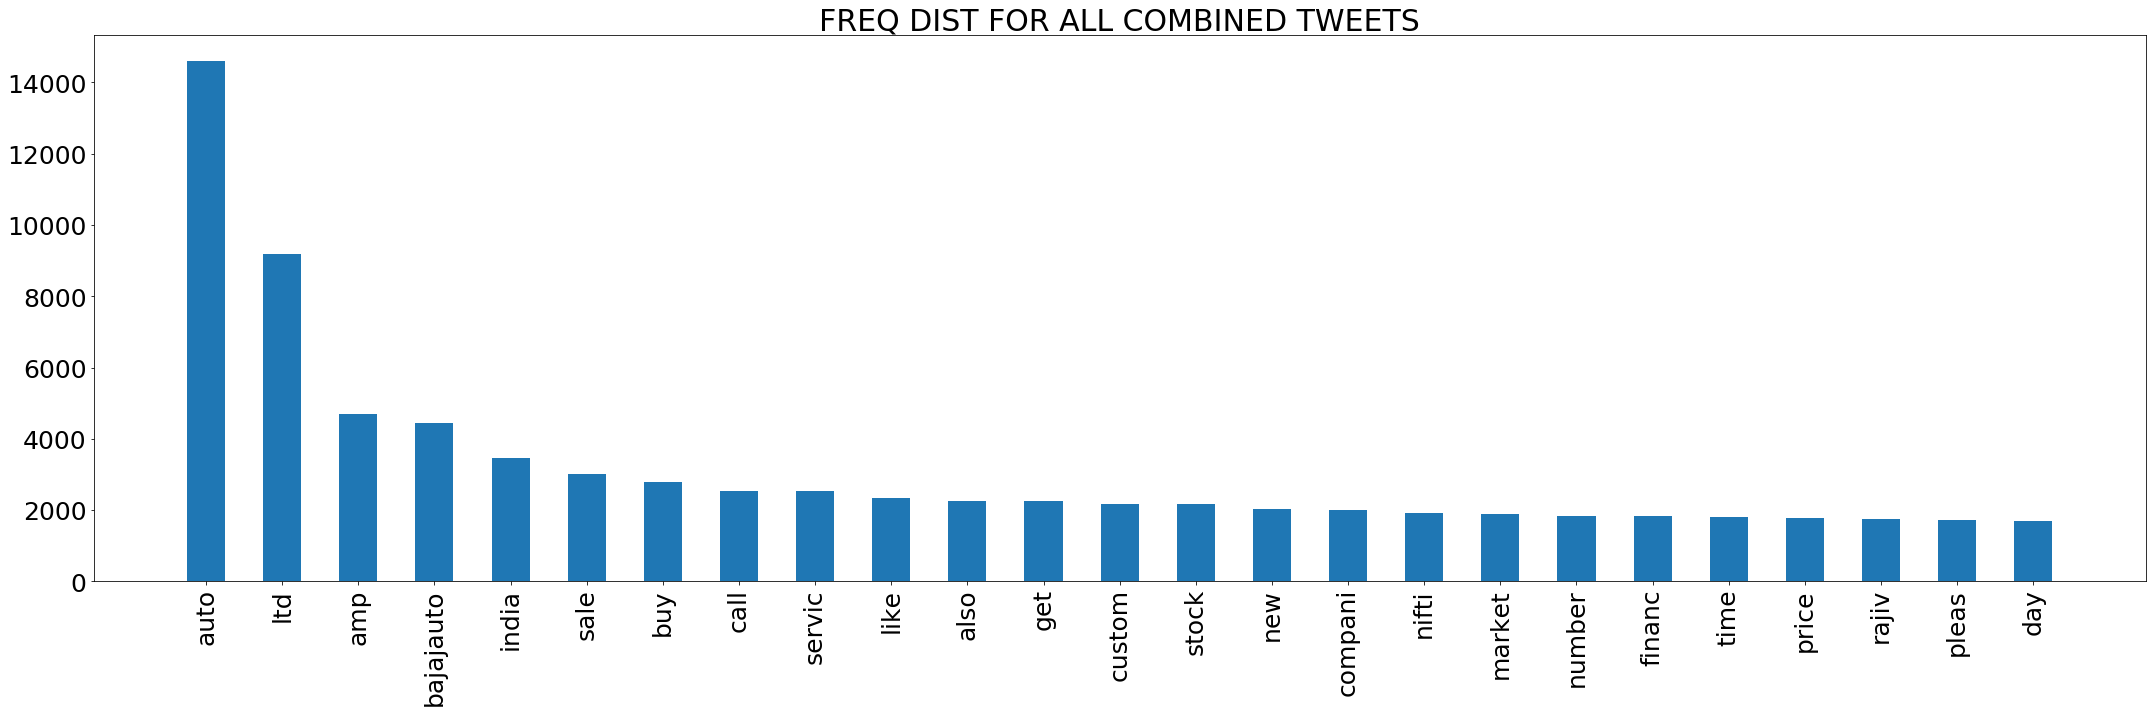

In [50]:
freqdists = get_freqdist(all_tweets)
plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][0:25],freqdists['freq'][0:25],width=0.5)
plt.title("FREQ DIST FOR ALL COMBINED TWEETS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

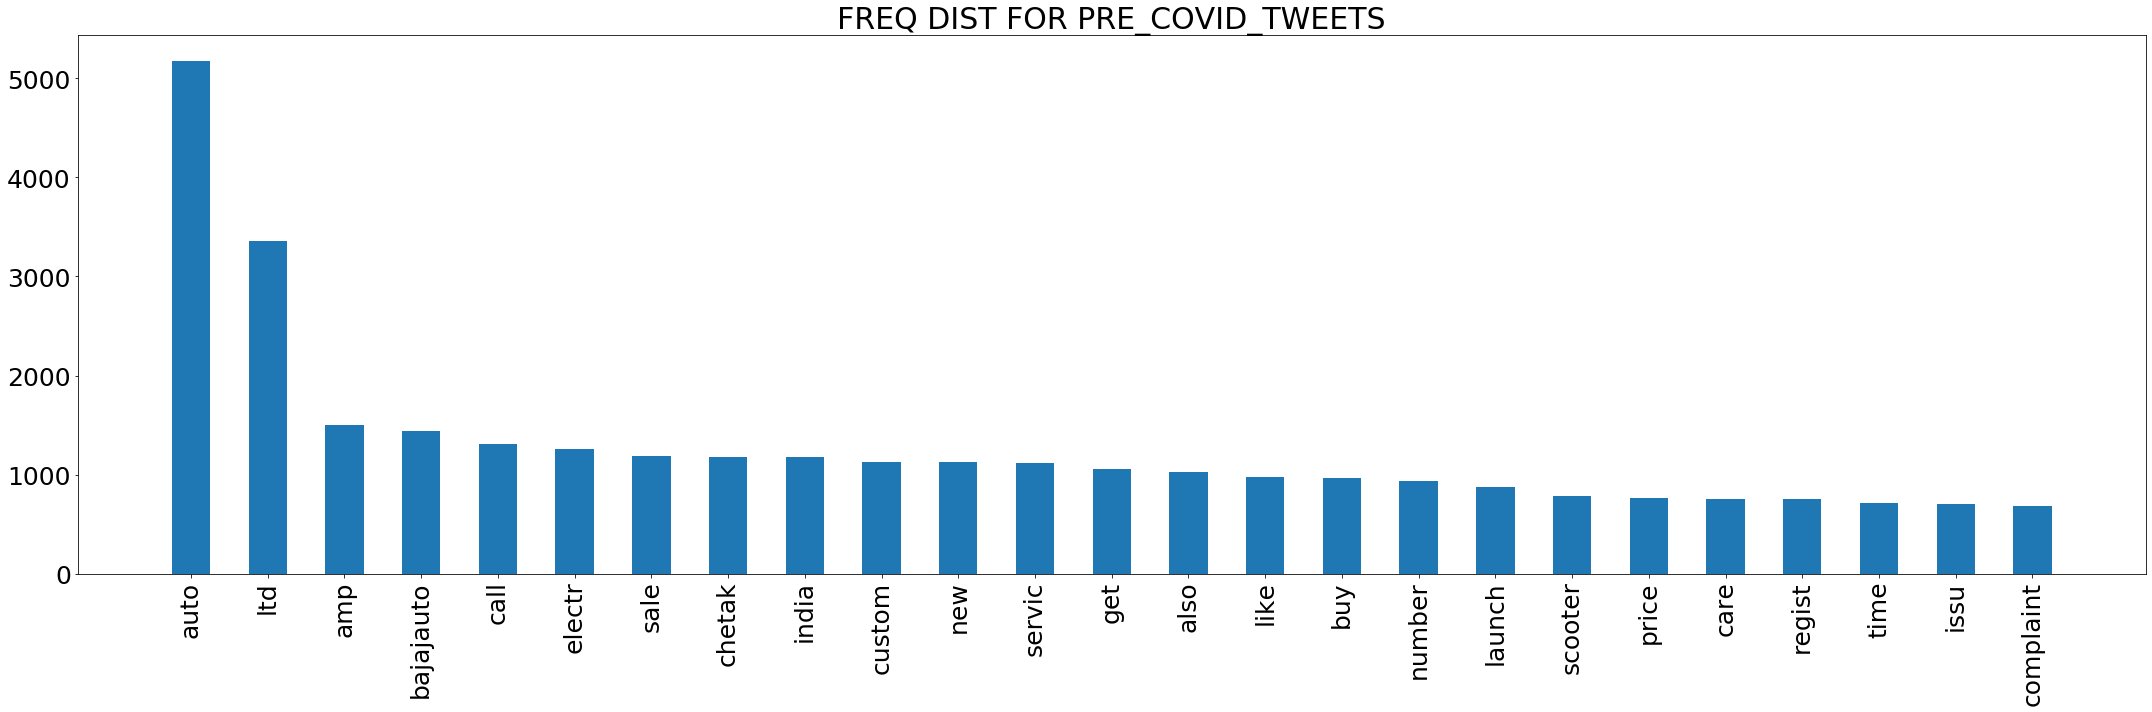

In [51]:
freqdists = get_freqdist(pre_covid_tweets)
plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][0:25],freqdists['freq'][0:25],width=0.5)
plt.title("FREQ DIST FOR PRE_COVID_TWEETS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

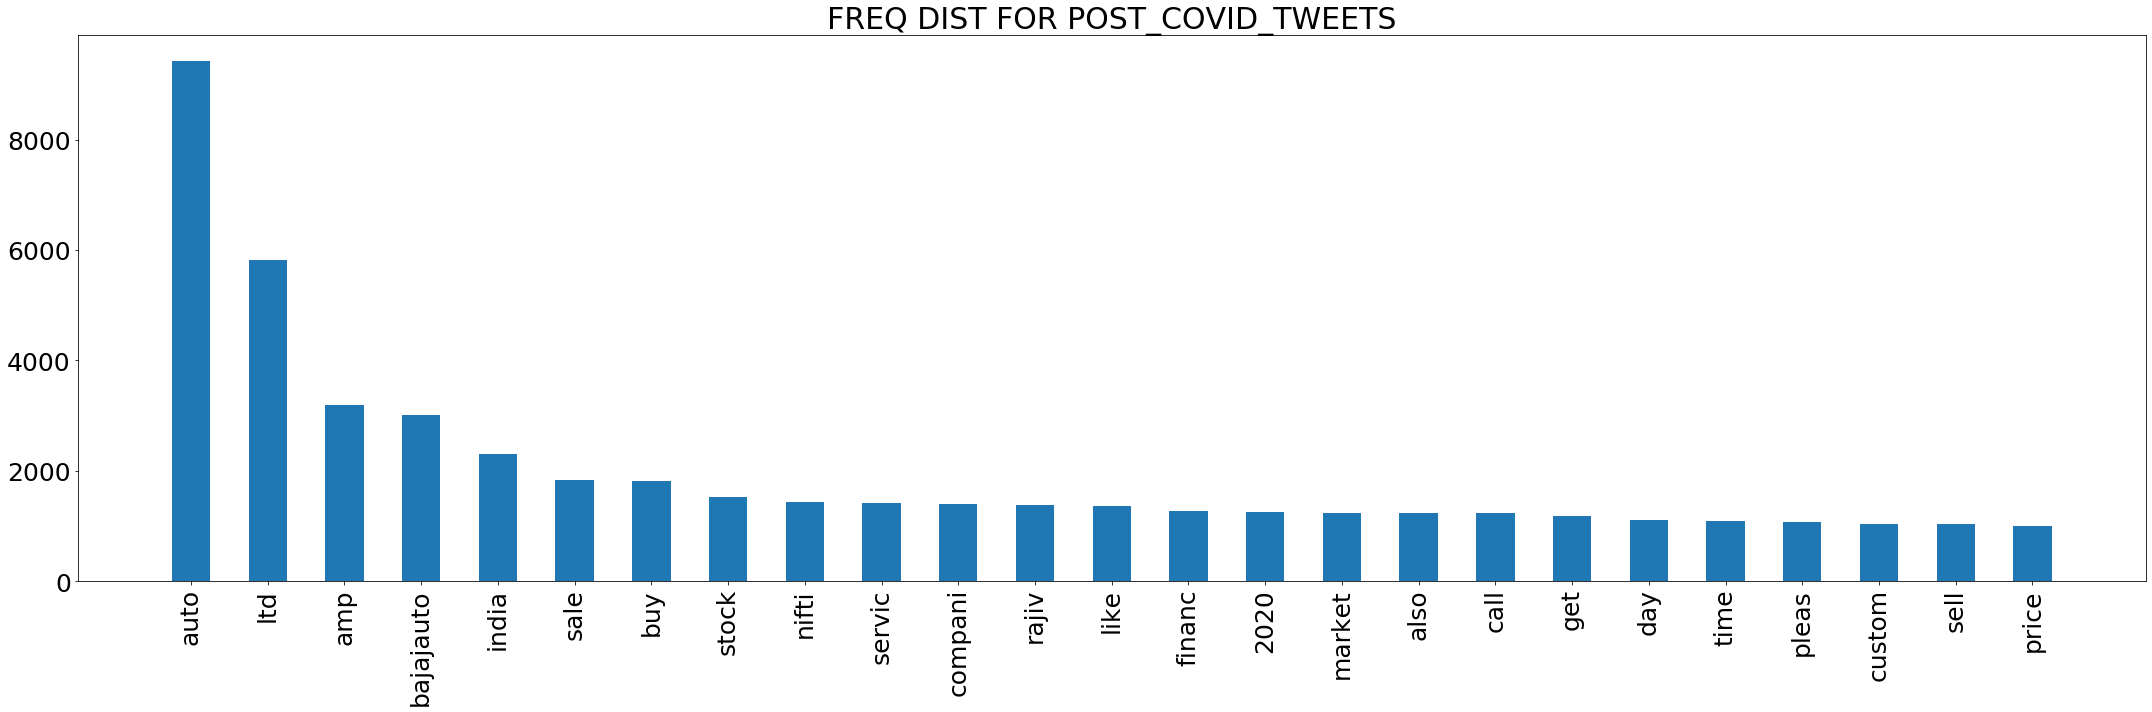

In [52]:
freqdists = get_freqdist(post_covid_tweets)
plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][0:25],freqdists['freq'][0:25],width=0.5)
plt.title("FREQ DIST FOR POST_COVID_TWEETS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [53]:
data = [[all_tweets.shape[0]],
         [pre_covid_tweets.shape[0]],
        [post_covid_tweets.shape[0]]]

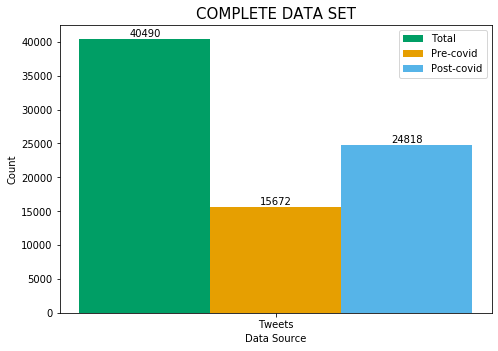

In [54]:
X = np.arange(1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = '#009E65', width = 0.25, label='Total')
ax.bar(X + 0.25, data[1], color = '#E69F01', width = 0.25, label='Pre-covid')
ax.bar(X + 0.50, data[2], color = '#56B4E8', width = 0.25, label='Post-covid')

ax.set_title('COMPLETE DATA SET',fontsize=15)
plt.xlabel('Data Source')
plt.ylabel('Count')
plt.xticks(X+0.25,['Tweets'])
plt.legend(loc="upper right")

rects = ax.patches

labels = [item for sublist in data for item in sublist] # converting list of list to a list

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

In [55]:
all_tweets_time = pd.concat([pre_covid_tweets,post_covid_tweets])

In [56]:
daily_count = pd.concat([all_tweets_time.groupby('Date').count()['ID']],axis=1)
daily_count.columns = ['Tweet Count']
daily_count.iplot(title='CUSTOMER DAILY TWEET COUNT',theme='white')

In [57]:
all_tweets_time['Date']=pd.to_datetime(all_tweets_time['Date'],infer_datetime_format=True)

monthly_count = pd.concat([all_tweets_time.groupby(all_tweets_time.Date.dt.to_period("M")).count()["ID"]],axis=1)
monthly_count.columns = ['Tweet Count']
monthly_count.iplot(title='MONTHLY COUNT',theme='white')

In [58]:
all_tweets_time = all_tweets_time.reset_index(drop=True) # Resetting index
split_data = all_tweets_time['Hashtags'].str.split(', ')
split_data.dropna(inplace=True)
split_data = split_data.reset_index(drop=True) # Dropping NaN values and resetting index

In [59]:
tags = []

for row in range(len(split_data)):
    tags.extend(split_data[row])
    
hashtags = [tag[1:-1] for tag in tags]

In [60]:
hashtags

['BAJAJ',
 'NimblrTA',
 'Amibroker',
 'Bajaj',
 'Bajaj',
 'Dominar250',
 'bajaj',
 'Pulsarman',
 'Pulsar',
 'intraday',
 'nifty50',
 'mukulagrawal',
 'technicalanalysis',
 'stockmarket',
 'india',
 'tatamotors',
 'reliance',
 'tcs',
 'mahindraandmahindra',
 'sbi',
 'google',
 'hdfcbank',
 'bajaj',
 'facebook',
 'ipl',
 'industrialsupplies',
 'workwear',
 'ppe',
 'hivis',
 'pulsar',
 'goretex',
 'DeepSpaceExploration',
 'SpaceTravel',
 'Pulsar',
 'Pulsarman',
 'Pulsar',
 'ITC',
 'IOC',
 'GAIL',
 'HEROMOTOCO',
 'COALINDIA',
 'ADANIPORTS',
 'ZEEL',
 'INDUSINDBK',
 'BRITANNIA',
 'BAJAJAUTO',
 'MARUTI',
 'BPCL',
 'ONGC',
 'BAJAJFINSV',
 'NESTLEIND',
 'ASIANPAINT',
 'EICHERMOT',
 'ULTRACEMCO',
 'UPL',
 'INFRATEL',
 'NTPC',
 'TITAN',
 'SUNPHARMA',
 'nifty50',
 'sensex',
 'nse',
 'bse',
 'markets',
 'stocks',
 'Husqvarna',
 'Svartpilen250',
 'Vitpilen250',
 'KTM',
 '250Duke',
 'Nifty',
 'ITC',
 'GAIL',
 'INDUSINDBK',
 'BAJAJAUTO',
 'BRITANNIA',
 'NTPC',
 'HEROMOTOCO',
 'TITAN',
 'HDFCBANK',
 '

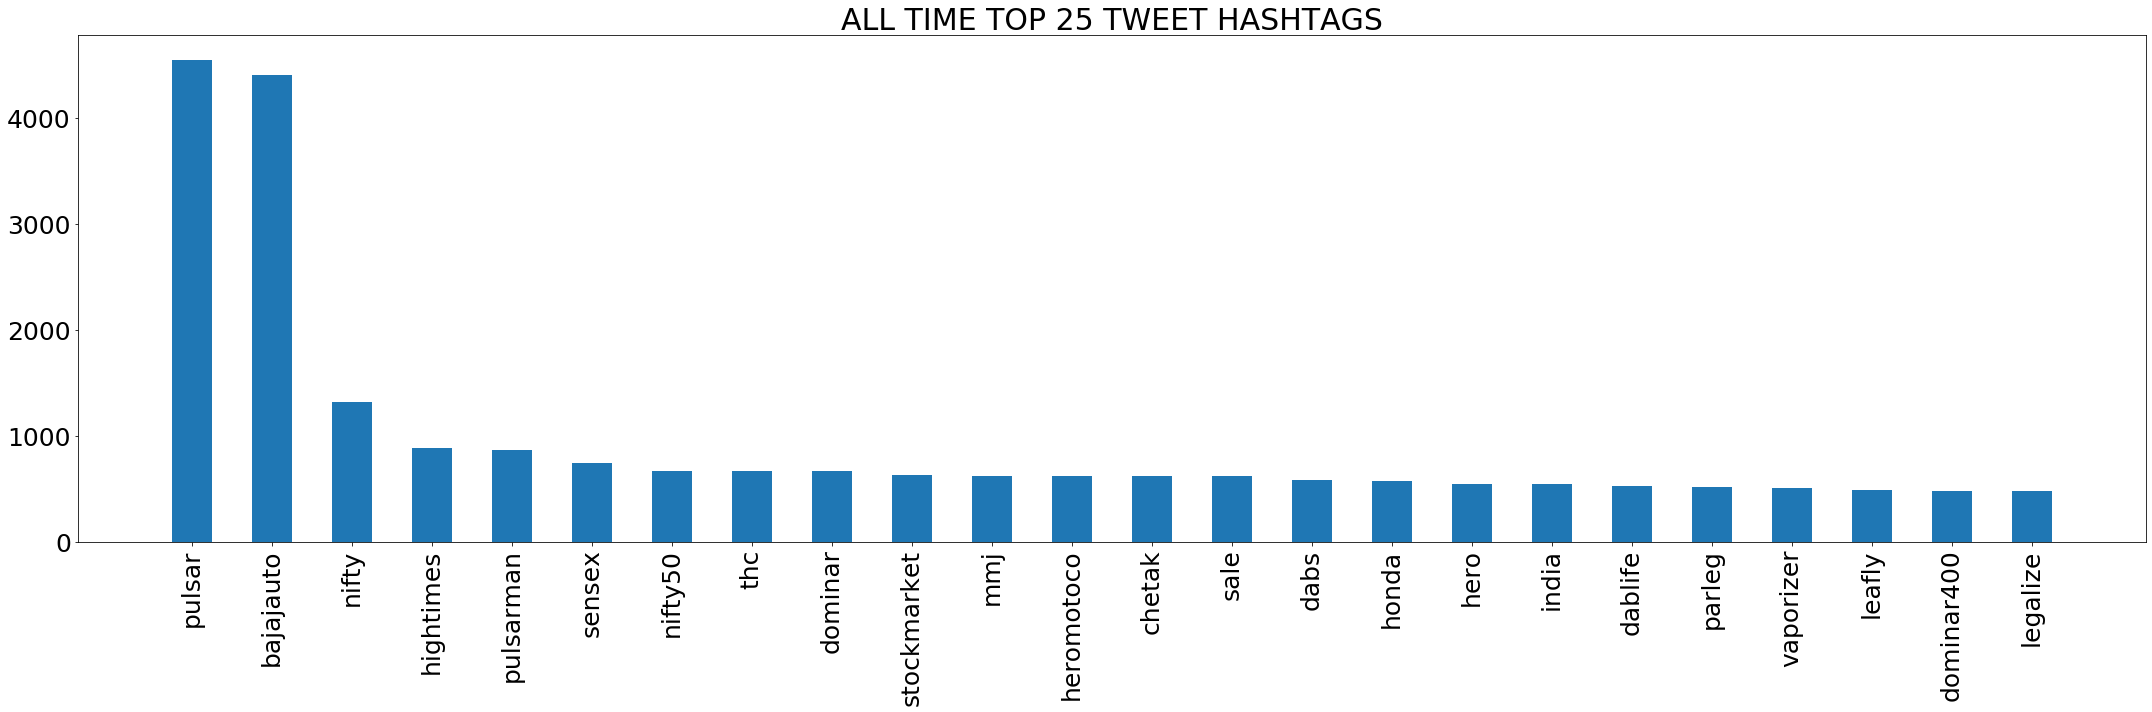

In [63]:
hashtags = [x.lower() for x in hashtags]
freqdists = pd.DataFrame(FreqDist(hashtags).items(), columns = ["words","freq"])
freqdists.sort_values(ascending=False, by="freq",inplace=True)
skipwords = ['bajaj','bajajauto','pulsar','dominar','avenger','ct100','chetak','Platina','pulsarNS']

plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][1:25],freqdists['freq'][1:25],width=0.5) # Excluding royalenfield
plt.title("ALL TIME TOP 25 TWEET HASHTAGS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [64]:
# Popular hashtags monthwise

pop_hashtag_month = all_tweets_time[all_tweets_time['Hashtags'].notnull()].groupby(all_tweets_time.Date.dt.to_period("M")).agg({'Hashtags':lambda line: ', '.join(line)})
pop_hashtag_month = pop_hashtag_month.reset_index()

pop_hashtags = []
pop_hashtags_freq = pd.DataFrame()

for item in range(pop_hashtag_month.shape[0]):
    
    tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(1)[0] # eval removes quotes from a string
    
    if tag in ['bajaj','bajajauto','pulsar','dominar','avenger','ct100','chetak','Platina','pulsarNS']: # filtering obvious tags
        tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(2)[1] # picking next best
        if tag in ['bajaj','bajajauto','pulsar','dominar','avenger','ct100','chetak','Platina','pulsarNS']:
            tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(3)[2] # picking next best
        
    pop_hashtags.append([tag,count])
    
pop_hashtags_freq = pd.DataFrame(pop_hashtags,columns=['Hashtag','Count'])
pop_hashtags_freq['Date'] = pop_hashtag_month['Date']
pop_hashtags_freq = pop_hashtags_freq[['Date','Hashtag','Count']]

In [65]:
pop_hashtags_freq

,Date,Hashtag,Count
0,2019-07,bajajauto,200
1,2019-08,bajajauto,136
2,2019-09,bajajauto,111
3,2019-10,bajajauto,292
4,2019-11,bajajauto,145
5,2019-12,rahulbajaj,138
6,2020-01,bajajauto,278
7,2020-02,bajajauto,123
8,2020-03,bajajauto,148
9,2020-04,bajajauto,231


In [66]:
annotations=dict(zip([pop_hashtags_freq['Date'][n].strftime('%Y-%m') for n in range(len(pop_hashtags_freq['Date']))],pop_hashtags_freq['Hashtag']))
pop_hashtags_freq.iplot(kind='bar',x='Date',y='Count',yTitle='Count',theme='white',annotations=annotations,title='MONTHLY TWEET HASHTAG POPULARITY')


In [67]:
def get_dtm_bigram(df):
    bigram_count_vectorizer = CountVectorizer(ngram_range=(2,2),stop_words=stop_updated,max_features=150)
    X_bigram = bigram_count_vectorizer.fit_transform(df['clean_tweets'])
    DTM_bigram = pd.DataFrame(X_bigram.toarray(), columns=bigram_count_vectorizer.get_feature_names())
    
    return DTM_bigram

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['auto', 'avenger', 'bajajauto', 'chetak', 'dominar', 'platina', 'pulasrns', 'street', 'wheeer'] not in stop_words.



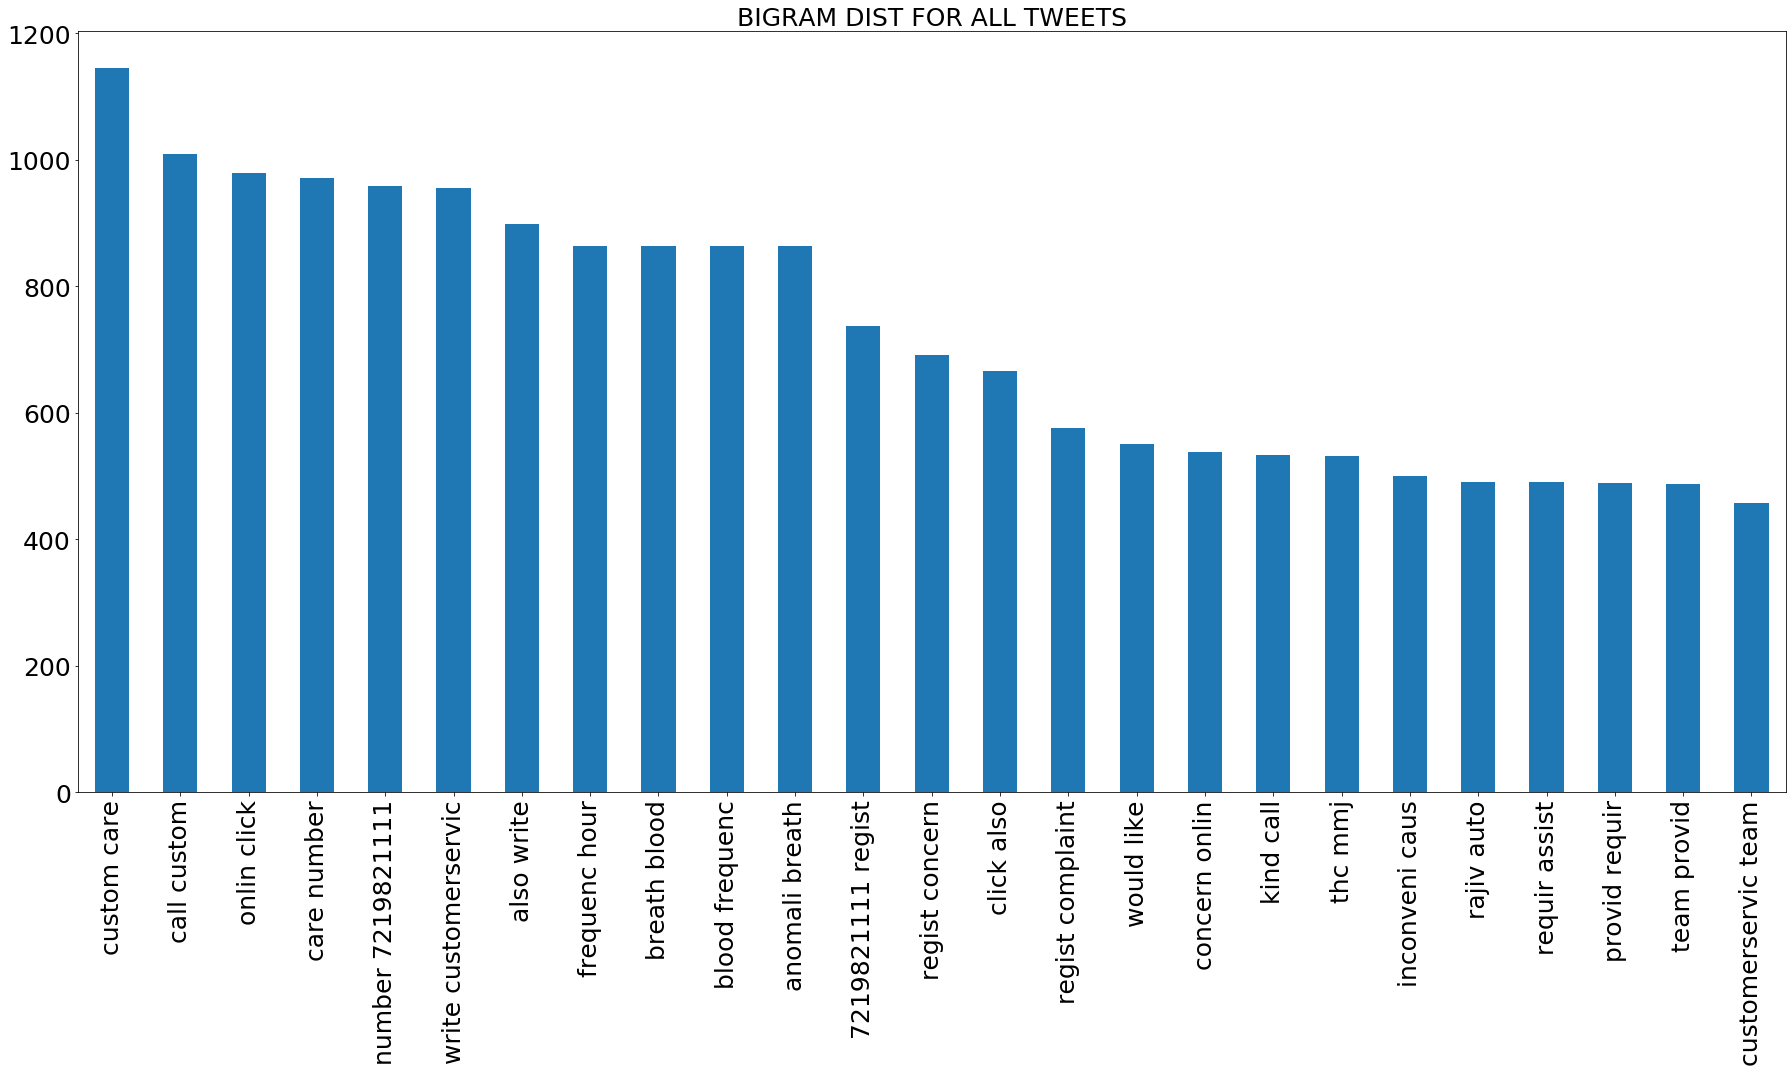

In [68]:
bigrams = get_dtm_bigram(all_tweets)
plt.figure(figsize=(25,15))
bigrams.sum().sort_values(ascending=False).head(25).plot.bar()  
plt.title("BIGRAM DIST FOR ALL TWEETS",fontsize=25)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['auto', 'avenger', 'bajajauto', 'chetak', 'dominar', 'platina', 'pulasrns', 'street', 'wheeer'] not in stop_words.



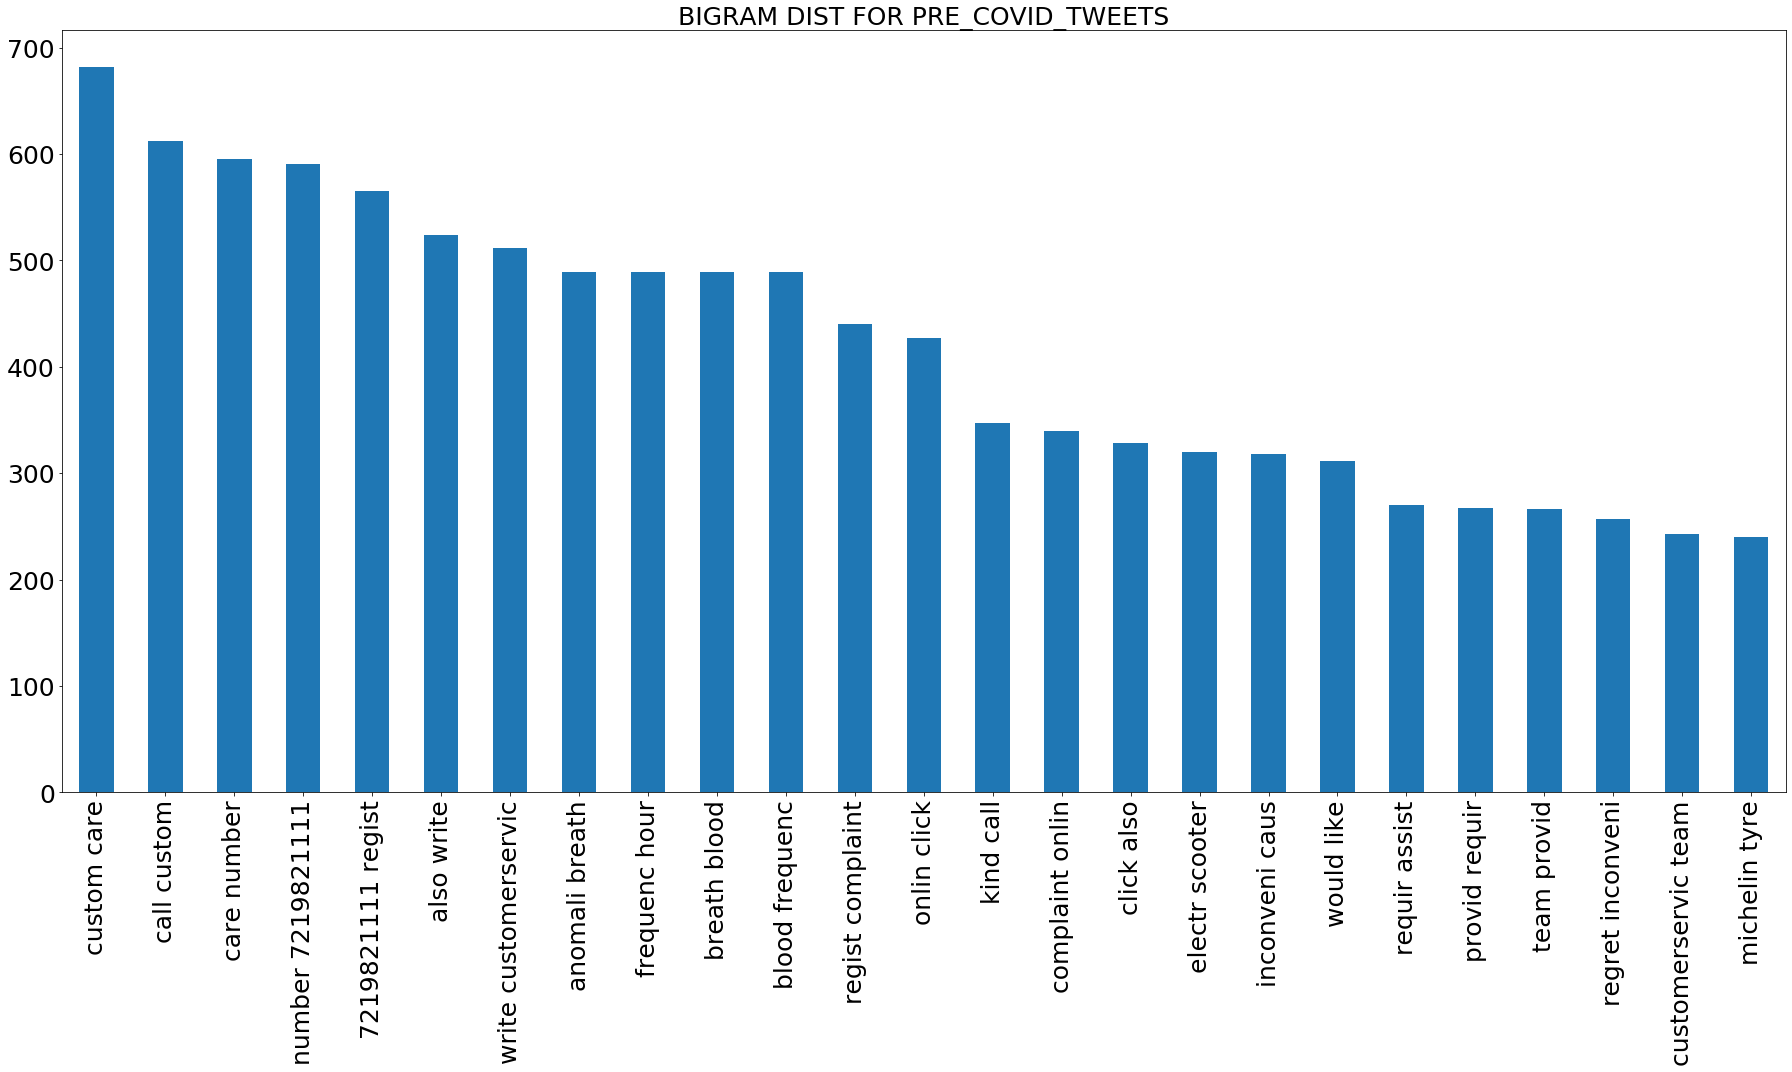

In [69]:
bigrams = get_dtm_bigram(pre_covid_tweets)
plt.figure(figsize=(25,15))
bigrams.sum().sort_values(ascending=False).head(25).plot.bar()  
plt.title("BIGRAM DIST FOR PRE_COVID_TWEETS",fontsize=25)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['auto', 'avenger', 'bajajauto', 'chetak', 'dominar', 'platina', 'pulasrns', 'street', 'wheeer'] not in stop_words.



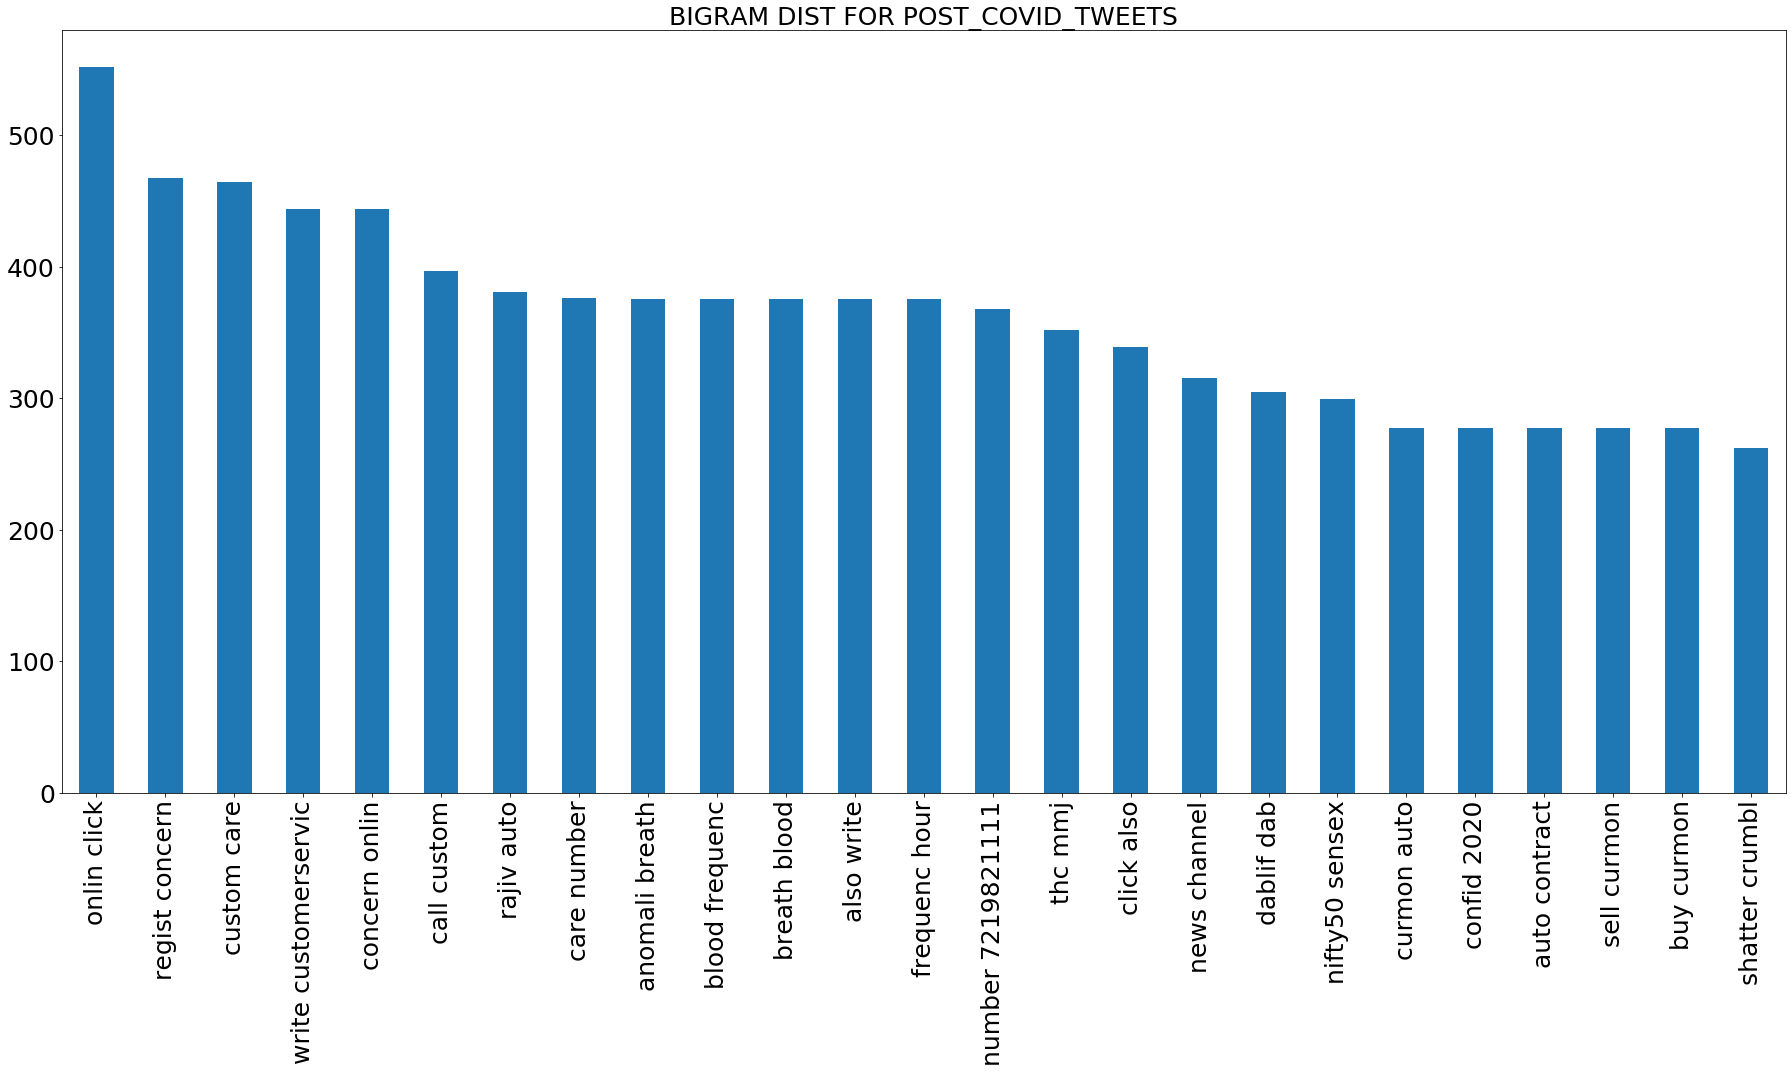

In [70]:
bigrams = get_dtm_bigram(post_covid_tweets)
plt.figure(figsize=(25,15))
bigrams.sum().sort_values(ascending=False).head(25).plot.bar()  
plt.title("BIGRAM DIST FOR POST_COVID_TWEETS",fontsize=25)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [72]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
senti = SentimentIntensityAnalyzer() 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...


In [73]:
def get_sentiment_vader(df):
    senti = SentimentIntensityAnalyzer()
    senti_score = [senti.polarity_scores(tweet)['compound'] for tweet in df['clean_tweets']]
    return senti_score

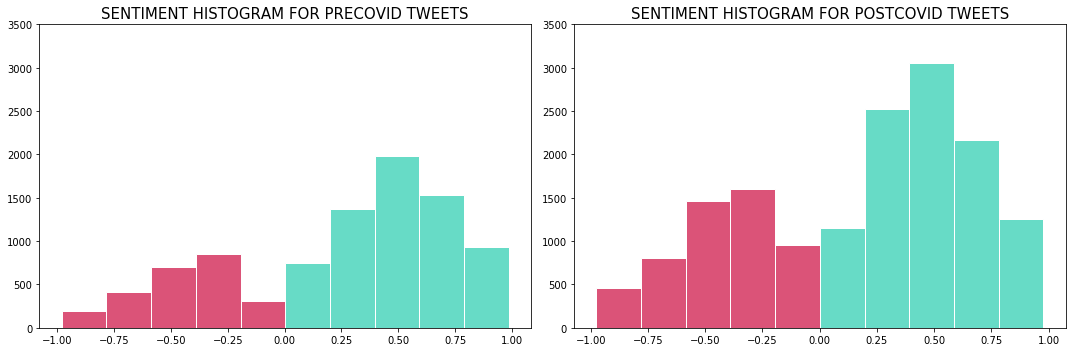

In [74]:
hists = [get_sentiment_vader(pre_covid_tweets),get_sentiment_vader(post_covid_tweets)]
fig,axes = plt.subplots(1,2,figsize=(15,5))

for i in range(len(hists)):
    
    # removing the neutral polarity values (values between 0.05 and -0.05)
    n,bins,patches=axes[i].hist([i for i in hists[i] if i >= 0.05 or i<=-0.05],facecolor='#67dbc6',edgecolor='white',linewidth=1)
    for p in patches[:5]:
        p.set_facecolor('#db5378')
    axes[i].set_title("SENTIMENT HISTOGRAM FOR "+periods[i].upper()+" TWEETS",fontsize=15)
    axes[i].set_ylim([0,3500])

plt.tight_layout()
plt.show()

In [75]:
def get_sentiment(df):
    
    senti_scores = get_sentiment_vader(df)
    df["Sentiment"]= ["Very Positive" if x>=0.5 else "Positive" if x<0.5 and x>=0.05 else "Negative" if x<=-0.05 and x>-0.5 else "Very Negative" if x<=-0.5 else "Neutral" for x in senti_scores]
    return df

In [76]:
get_sentiment(all_tweets_time)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets,Sentiment
0,1233303197277675520,2020-02-28,Reversal Buy #BAJAJ-AUTO 2901.15 28/02/20 1:30...,"'BAJAJ', 'NimblrTA', 'Amibroker'",NaN,revers buy auto 2901 2851 2971 nimblrta amibro...,Neutral
1,1233388534838390784,2020-02-28,#Bajaj Finance strict SL 4300 buy for 5500+ le...,'Bajaj',NaN,financ strict 4300 buy 5500 level,Neutral
2,1233357960279134208,2020-02-28,"Ladies and gentlemen, #Bajaj is all set to lau...","'Bajaj', 'Dominar250', 'bajaj'",NaN,ladi gentlemen set launch smaller dominar250 i...,Neutral
3,1233501153851314176,2020-02-28,23:13 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN,anomali breath blood frequenc hour 124 31811 p...,Neutral
4,1233217757942046720,2020-02-28,"The Strongest Brands ranked on Trust, Online P...","'intraday', 'nifty50', 'mukulagrawal', 'techni...",NaN,strongest brand rank trust onlin prefer brand ...,Very Positive
...,...,...,...,...,...,...,...
40485,1234222082260635648,2020-03-01,23:00 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN,anomali breath blood frequenc hour 31859 pulsa...,Neutral
40486,1234228124126240768,2020-03-01,One of three variants of this Pulsar watch #wo...,"'wotd', 'watchoftheday', 'watchesofinstagram',...",NaN,one three variant watch wotd watchoftheday wat...,Neutral
40487,1233960925993943040,2020-03-01,#Appuppanthadi aka #milkweed #fluff falls on #...,"'Appuppanthadi', 'milkweed', 'fluff', 'Domi', ...",NaN,appuppanthadi aka milkwe fluff fall domi domin...,Neutral
40488,1233954365599125504,2020-03-01,The season for #Umbadiyu is almost over! I rod...,"'Umbadiyu', 'Dominar'",NaN,season umbadiyu almost rode dominar mumbai val...,Neutral


In [77]:
get_sentiment(pre_covid_tweets)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets,Sentiment
1,1233303197277675520,2020-02-28,Reversal Buy #BAJAJ-AUTO 2901.15 28/02/20 1:30...,"'BAJAJ', 'NimblrTA', 'Amibroker'",NaN,revers buy auto 2901 2851 2971 nimblrta amibro...,Neutral
22,1233388534838390784,2020-02-28,#Bajaj Finance strict SL 4300 buy for 5500+ le...,'Bajaj',NaN,financ strict 4300 buy 5500 level,Neutral
24,1233357960279134208,2020-02-28,"Ladies and gentlemen, #Bajaj is all set to lau...","'Bajaj', 'Dominar250', 'bajaj'",NaN,ladi gentlemen set launch smaller dominar250 i...,Neutral
4163,1233501153851314176,2020-02-28,23:13 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN,anomali breath blood frequenc hour 124 31811 p...,Neutral
28,1233217757942046720,2020-02-28,"The Strongest Brands ranked on Trust, Online P...","'intraday', 'nifty50', 'mukulagrawal', 'techni...",NaN,strongest brand rank trust onlin prefer brand ...,Very Positive
...,...,...,...,...,...,...,...
16788,1145560845218267136,2019-07-01,Benchmark indices are trading higher today on ...,"'Sensex', 'Nifty'",NaN,benchmark indic trade higher today strong glob...,Very Positive
16786,1145613778920198144,2019-07-01,*Bajaj Auto June'19 Sales marginally below exp...,'news',NaN,auto june sale margin expect total sale came 4...,Neutral
16783,1145575864597450752,2019-07-01,June #Auto Sales\n\nBajaj Auto \nTotal Sales f...,'Auto',NaN,june auto sale auto total sale flat unit domes...,Neutral
16729,1145659650701963264,2019-07-01,Sensex soars 292 points on easing trade war co...,NaN,NaN,sensex soar 292 point eas trade war concern ta...,Negative


In [78]:
get_sentiment(post_covid_tweets)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets,Sentiment
9353,1340268501538205696,2020-12-19,@bajaj_ltd services very bad experiences I ha...,NaN,bajaj_ltd,ltd servic bad experi got meera road suryoday ...,Negative
21,1340284273274757120,2020-12-19,#bajaj v12 is the worst bike bajaj had looted ...,'bajaj',NaN,v12 worst loot money face troubl want answer p...,Very Negative
17129,1340341135596609536,2020-12-19,#BAJAJ_AUTO - BAJAJ ABOVE 3380 CAN BREAKOUT - ...,'BAJAJ_AUTO',NaN,auto 3380 breakout tradingview,Neutral
6563,1340106550141136896,2020-12-19,15% Off #Pulsar #APX V2 #Vaporizer\n @ https:/...,"'Pulsar', 'APX', 'Vaporizer', 'Vape', 'Dablife...",NaN,apx vapor use code holiday15 vape dablif hight...,Positive
9338,1340206317907161088,2020-12-19,Dear @sanjivrbajaj @bajaj_ltd We searched for ...,NaN,sanjivrbajaj,dear ltd search rahul sir amp rajiv twitter ha...,Very Positive
...,...,...,...,...,...,...,...
8856,1234222082260635648,2020-03-01,23:00 Anomaly breathing blood. Frequency/hour ...,"'Pulsarman', 'Pulsar'",NaN,anomali breath blood frequenc hour 31859 pulsa...,Neutral
8857,1234228124126240768,2020-03-01,One of three variants of this Pulsar watch #wo...,"'wotd', 'watchoftheday', 'watchesofinstagram',...",NaN,one three variant watch wotd watchoftheday wat...,Neutral
9247,1233960925993943040,2020-03-01,#Appuppanthadi aka #milkweed #fluff falls on #...,"'Appuppanthadi', 'milkweed', 'fluff', 'Domi', ...",NaN,appuppanthadi aka milkwe fluff fall domi domin...,Neutral
9266,1233954365599125504,2020-03-01,The season for #Umbadiyu is almost over! I rod...,"'Umbadiyu', 'Dominar'",NaN,season umbadiyu almost rode dominar mumbai val...,Neutral


### Sentiment Variation over Time 

In [79]:
all_tweets_time = all_tweets_time[['Date','Sentiment']]
all_tweets_time.sort_values(ascending=False, by="Date",inplace=True)

# Creating a dummy column for count
all_tweets_time['ID'] = range(0,len(all_tweets_time))

all_tweets_time.groupby(['Date','Sentiment']).count()['ID'].unstack().iplot(colors=['#de7a95','#DBCF64','#67DBC6','#DB5378','#43a896'],
                                                                           title='TWEETS SENTIMENT VARIATION',
                                                                           yTitle='Count',
                                                                           theme='white')

In [81]:
import seaborn as sns

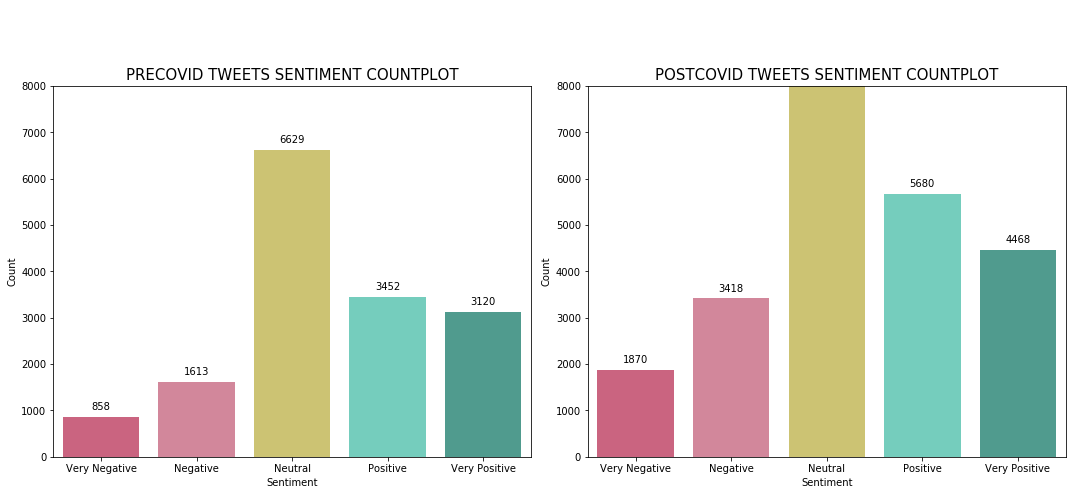

In [82]:
cplots = [pre_covid_tweets['Sentiment'],post_covid_tweets['Sentiment']]

fig,axes = plt.subplots(1,2,figsize=(15,7))

for i in range(len(cplots)):

    ax = sns.countplot(cplots[i],order=['Very Negative','Negative','Neutral','Positive','Very Positive'],
                                palette=['#DB5378','#de7a95','#DBCF64','#67DBC6','#43a896'],ax=axes[i])
    axes[i].set_title(periods[i].upper()+' TWEETS SENTIMENT COUNTPLOT',fontsize=15)
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Count')
    axes[i].set_ylim([0,8000])

    for p in ax.patches:
        ax.annotate(format(p.get_height(), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [83]:
pre_covid_disrt=pre_covid_tweets['Sentiment'].value_counts()/pre_covid_tweets.shape[0]
pre_covid_disrt

Neutral          0.422984
Positive         0.220265
Very Positive    0.199081
Negative         0.102922
Very Negative    0.054747
Name: Sentiment, dtype: float64

In [84]:
post_covid_distr=post_covid_tweets['Sentiment'].value_counts(normalize=True)
post_covid_distr

Neutral          0.378032
Positive         0.228866
Very Positive    0.180031
Negative         0.137723
Very Negative    0.075349
Name: Sentiment, dtype: float64

In [85]:
all_tweets_distr=all_tweets_time['Sentiment'].value_counts(normalize=True)
all_tweets_distr

Neutral          0.395431
Positive         0.225537
Very Positive    0.187404
Negative         0.124253
Very Negative    0.067375
Name: Sentiment, dtype: float64

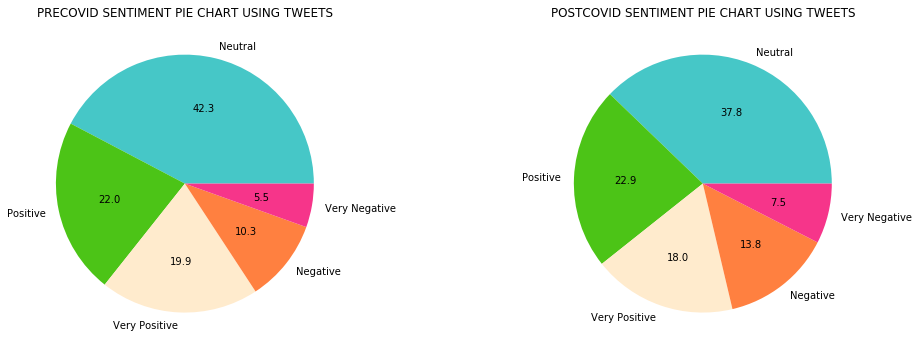

In [105]:
distr=[pre_covid_disrt,post_covid_distr]
fig,axes = plt.subplots(1,2,figsize=(15,5)); #axes.axis("equal")

for i in range(len(distr)):
    
    axes[i].pie(distr[i].values,labels=list(distr[i].keys()),autopct='%1.1f',colors=['#46C7C7','#4CC417','#FFEBCD','#FF8040','#F6358A'])
    axes[i].title.set_text(periods[i].upper()+" SENTIMENT PIE CHART USING TWEETS")
    
plt.tight_layout()
plt.show()

In [87]:
 nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [88]:
neg_dist_tweets = get_freqdist(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]))
pos_dist_tweets = get_freqdist(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]))

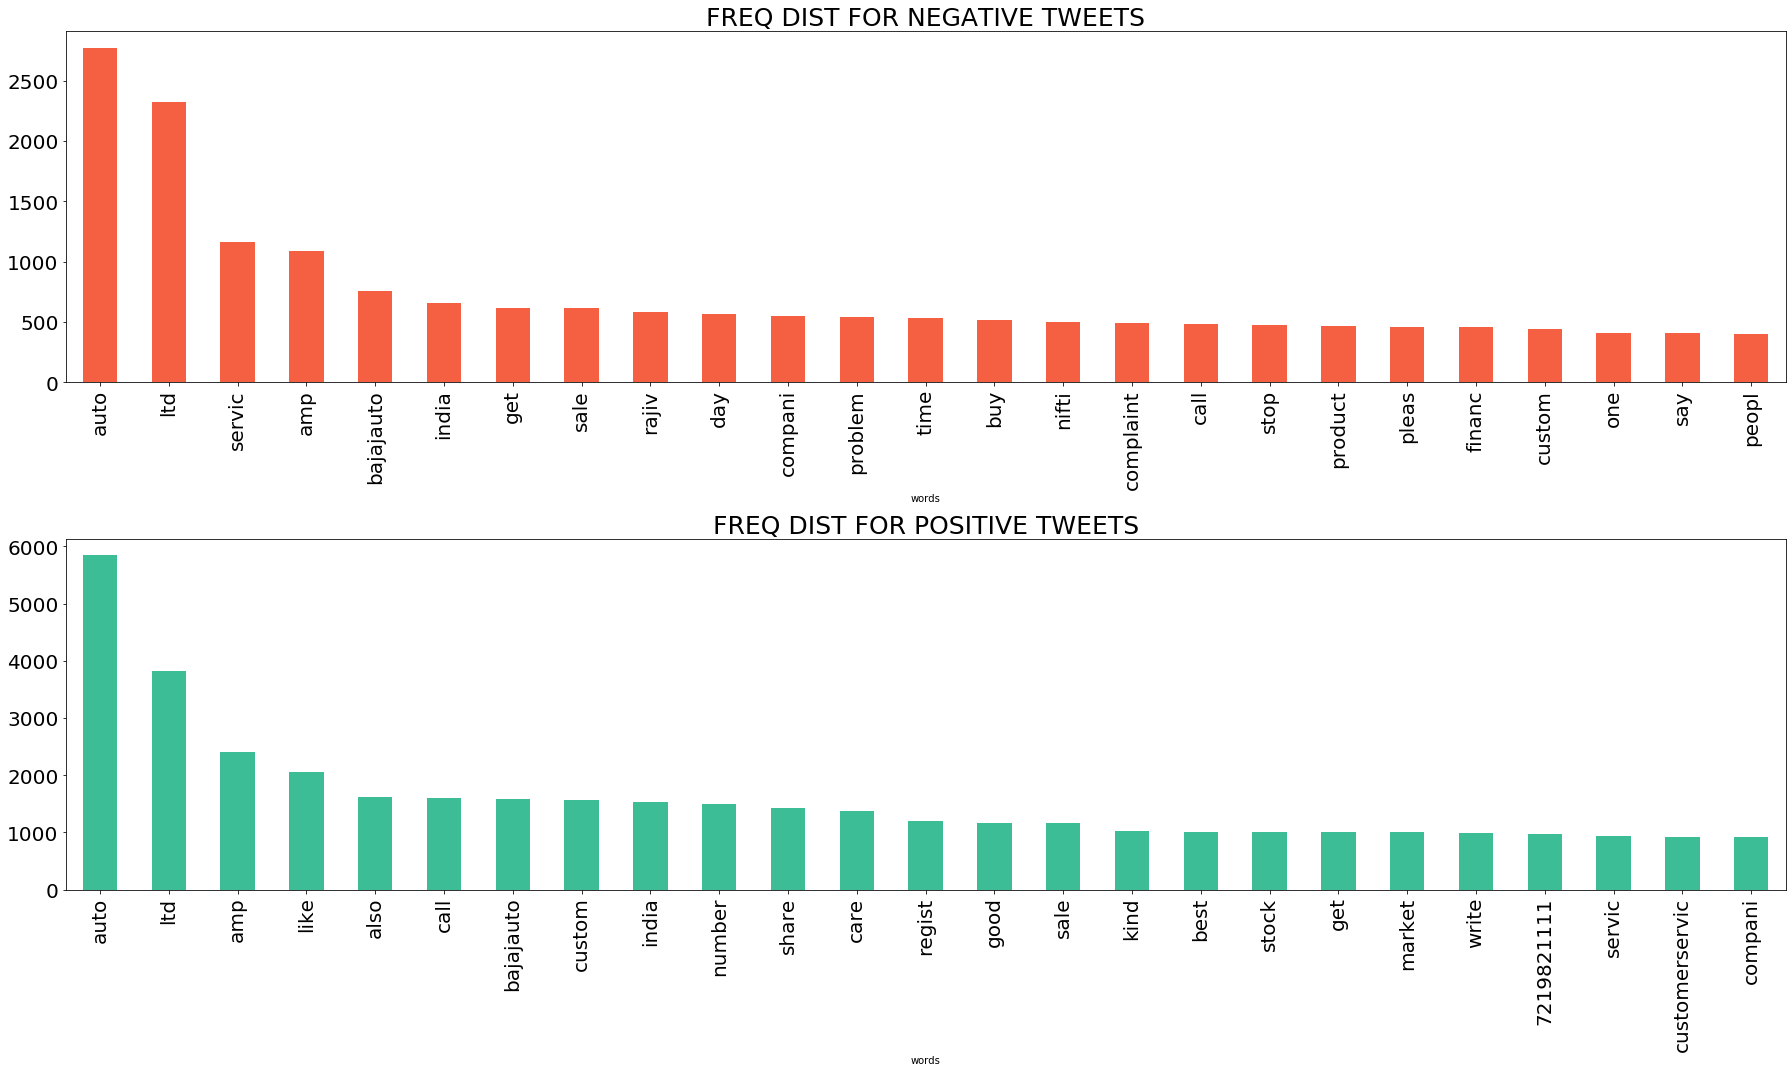

In [89]:
freqdists = [neg_dist_tweets,pos_dist_tweets]
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
fig,axes = plt.subplots(2,1,figsize=(25,15))
for i in range(len(freqdists)):
    freqdists[i].head(25).plot.bar(x='words',y='freq',ax=axes[i],color=colors[i])
    axes[i].set_title("FREQ DIST FOR "+names[i]+" TWEETS",fontsize=25)
    #axes[i].set_xlabel('',fontsize=20)
    #axes[i].set_ylabel('Count',fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

## Bigrams based on Sentiment 

In [90]:
neg_big_tweets = get_dtm_bigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]))
pos_big_tweets = get_dtm_bigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]))

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['auto', 'avenger', 'bajajauto', 'chetak', 'dominar', 'platina', 'pulasrns', 'street', 'wheeer'] not in stop_words.

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['auto', 'avenger', 'bajajauto', 'chetak', 'dominar', 'platina', 'pulasrns', 'street', 'wheeer'] not in stop_words.



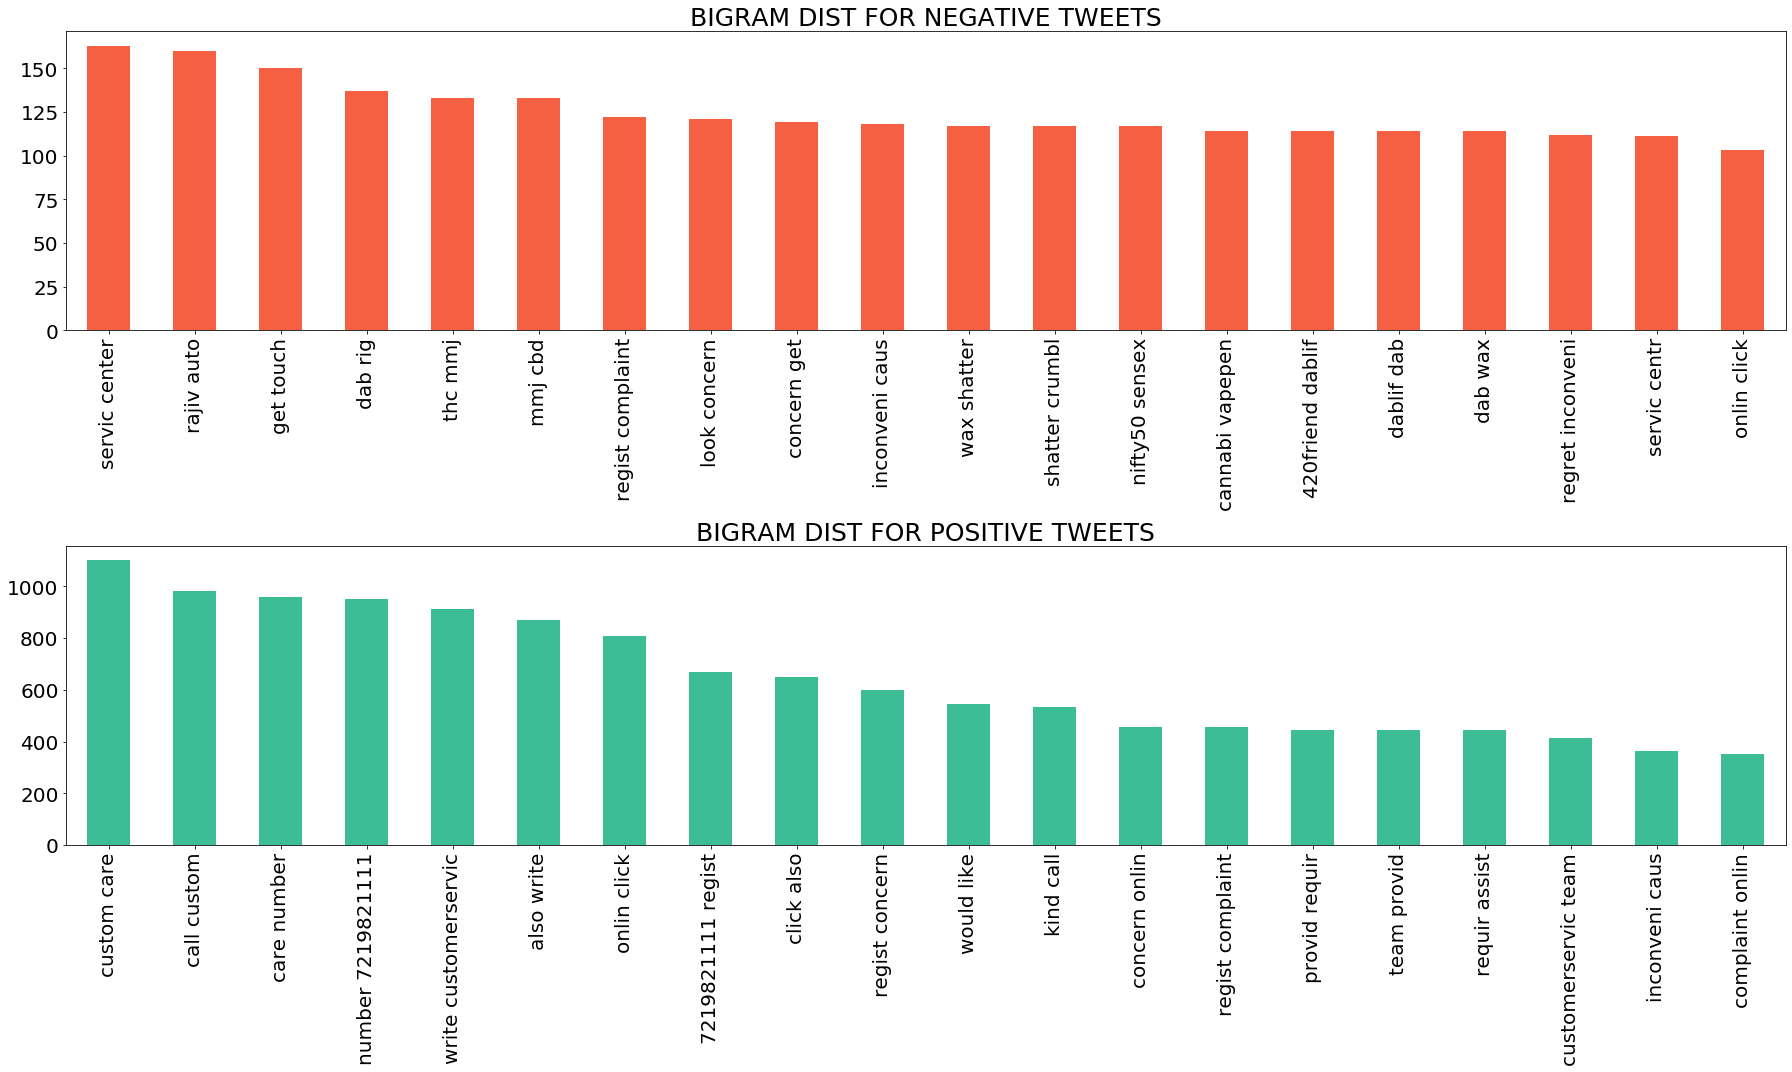

In [91]:
bigrams = [neg_big_tweets,pos_big_tweets]
fig,axes = plt.subplots(2,1,figsize=(25,15))
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
for i in range(len(bigrams)):    
    
    bigrams[i].sum().sort_values(ascending=False).head(20).plot.bar(ax=axes[i],color=colors[i])  
    axes[i].set_title("BIGRAM DIST FOR "+names[i]+" TWEETS",fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    
plt.tight_layout()    
plt.show()

In [92]:
def get_dtm_trigram(df):
    
    # create a trigram count vectorizer object
    trigram_count_vectorizer = CountVectorizer(ngram_range=(3,3),stop_words=stop_updated,max_features=150)
    X_trigram = trigram_count_vectorizer.fit_transform(df['clean_tweets'])
    # Creating a DTM
    DTM_trigram = pd.DataFrame(X_trigram.toarray(), columns=trigram_count_vectorizer.get_feature_names())
    return DTM_trigram

In [93]:
neg_tri_tweets = get_dtm_trigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]))
pos_tri_tweets = get_dtm_trigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]))

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['auto', 'avenger', 'bajajauto', 'chetak', 'dominar', 'platina', 'pulasrns', 'street', 'wheeer'] not in stop_words.

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['auto', 'avenger', 'bajajauto', 'chetak', 'dominar', 'platina', 'pulasrns', 'street', 'wheeer'] not in stop_words.



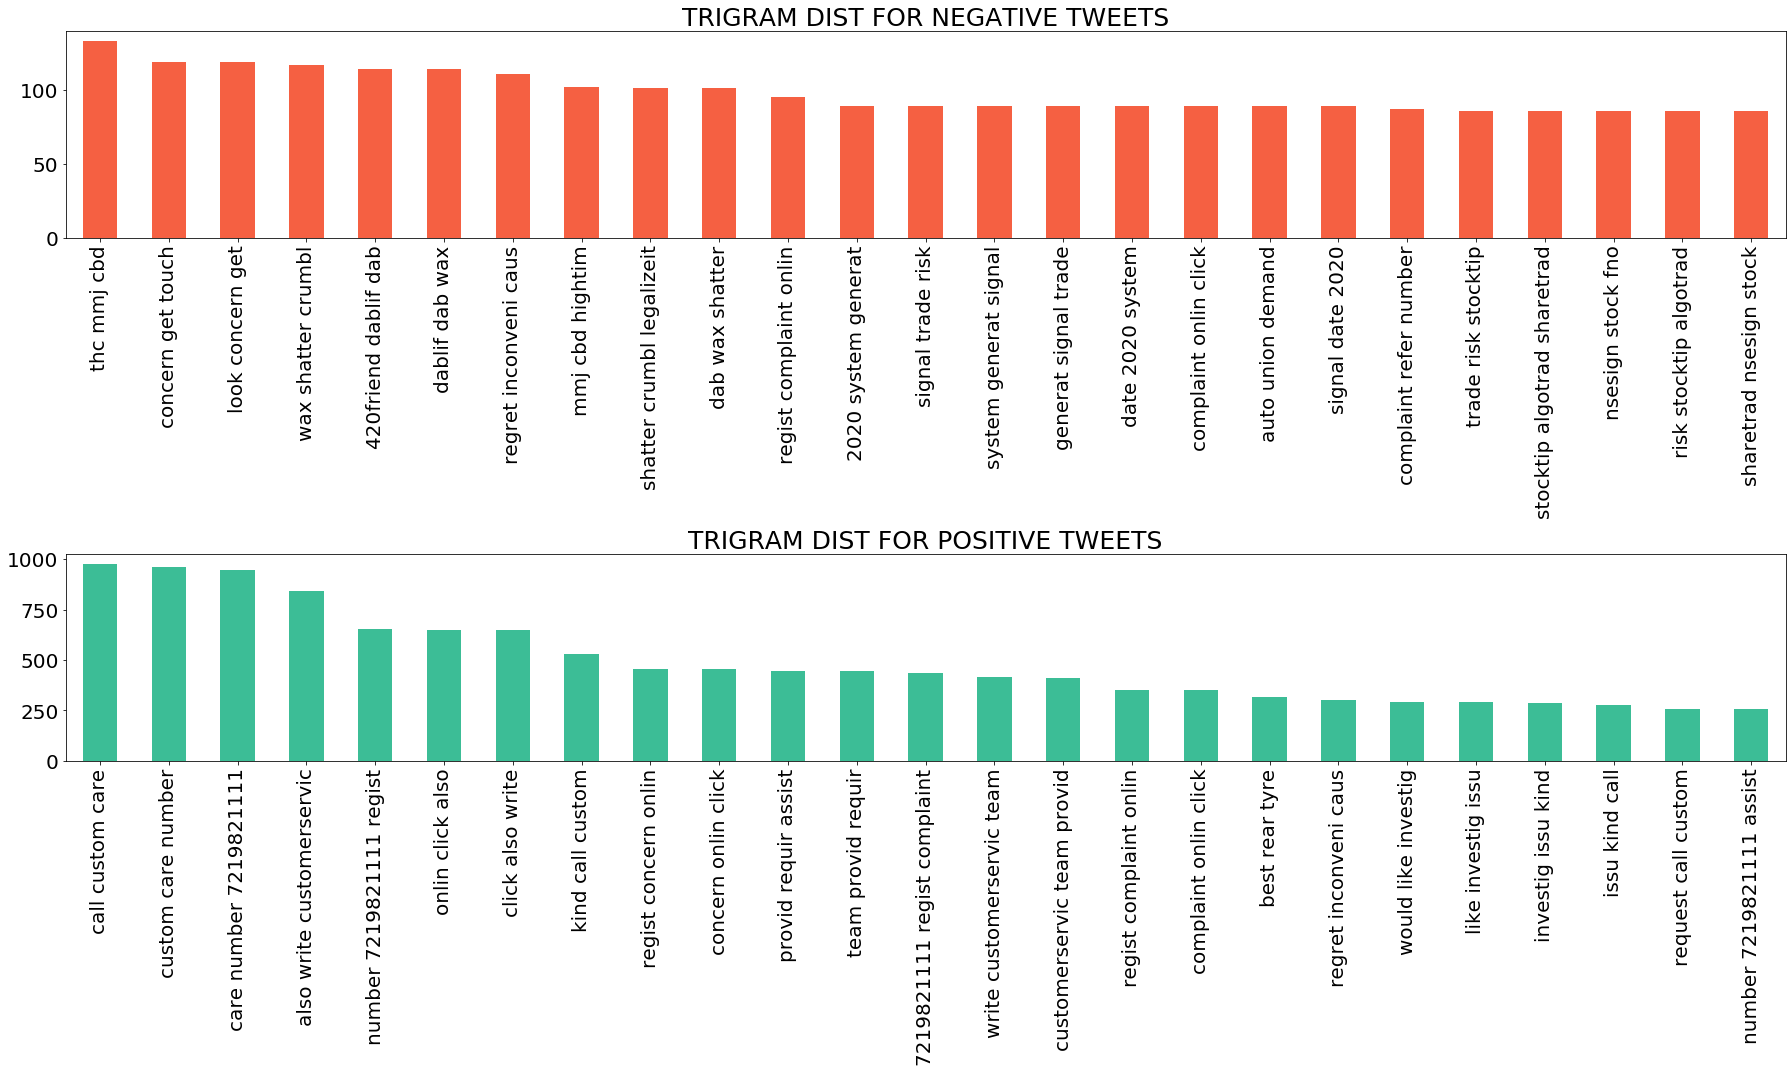

In [94]:
trigrams = [neg_tri_tweets,pos_tri_tweets]
fig,axes = plt.subplots(2,1,figsize=(25,15))
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
for i in range(len(trigrams)):    
    
    trigrams[i].sum().sort_values(ascending=False).head(25).plot.bar(ax=axes[i],color=colors[i])  
    axes[i].set_title("TRIGRAM DIST FOR "+names[i]+" TWEETS",fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    
plt.tight_layout()    
plt.show()

In [95]:
def get_freqdist_pos(df,tag):
    
    comb_tweets = " ".join(df['clean_tweets'].values)
    all_terms = word_tokenize(comb_tweets)
    tagged = nltk.pos_tag([x for x in all_terms if x not in stop_updated]) # Removing stop words
    result = [(w1,t1) for (w1, t1) in tagged if t1 == tag]    
    tag_fd = nltk.FreqDist(word for (word, tag) in result)
    df_dist = pd.DataFrame(tag_fd.items(), columns = ["words","freq"])
    df_dist.sort_values(ascending=False, by="freq",inplace=True)
    
    return df_dist

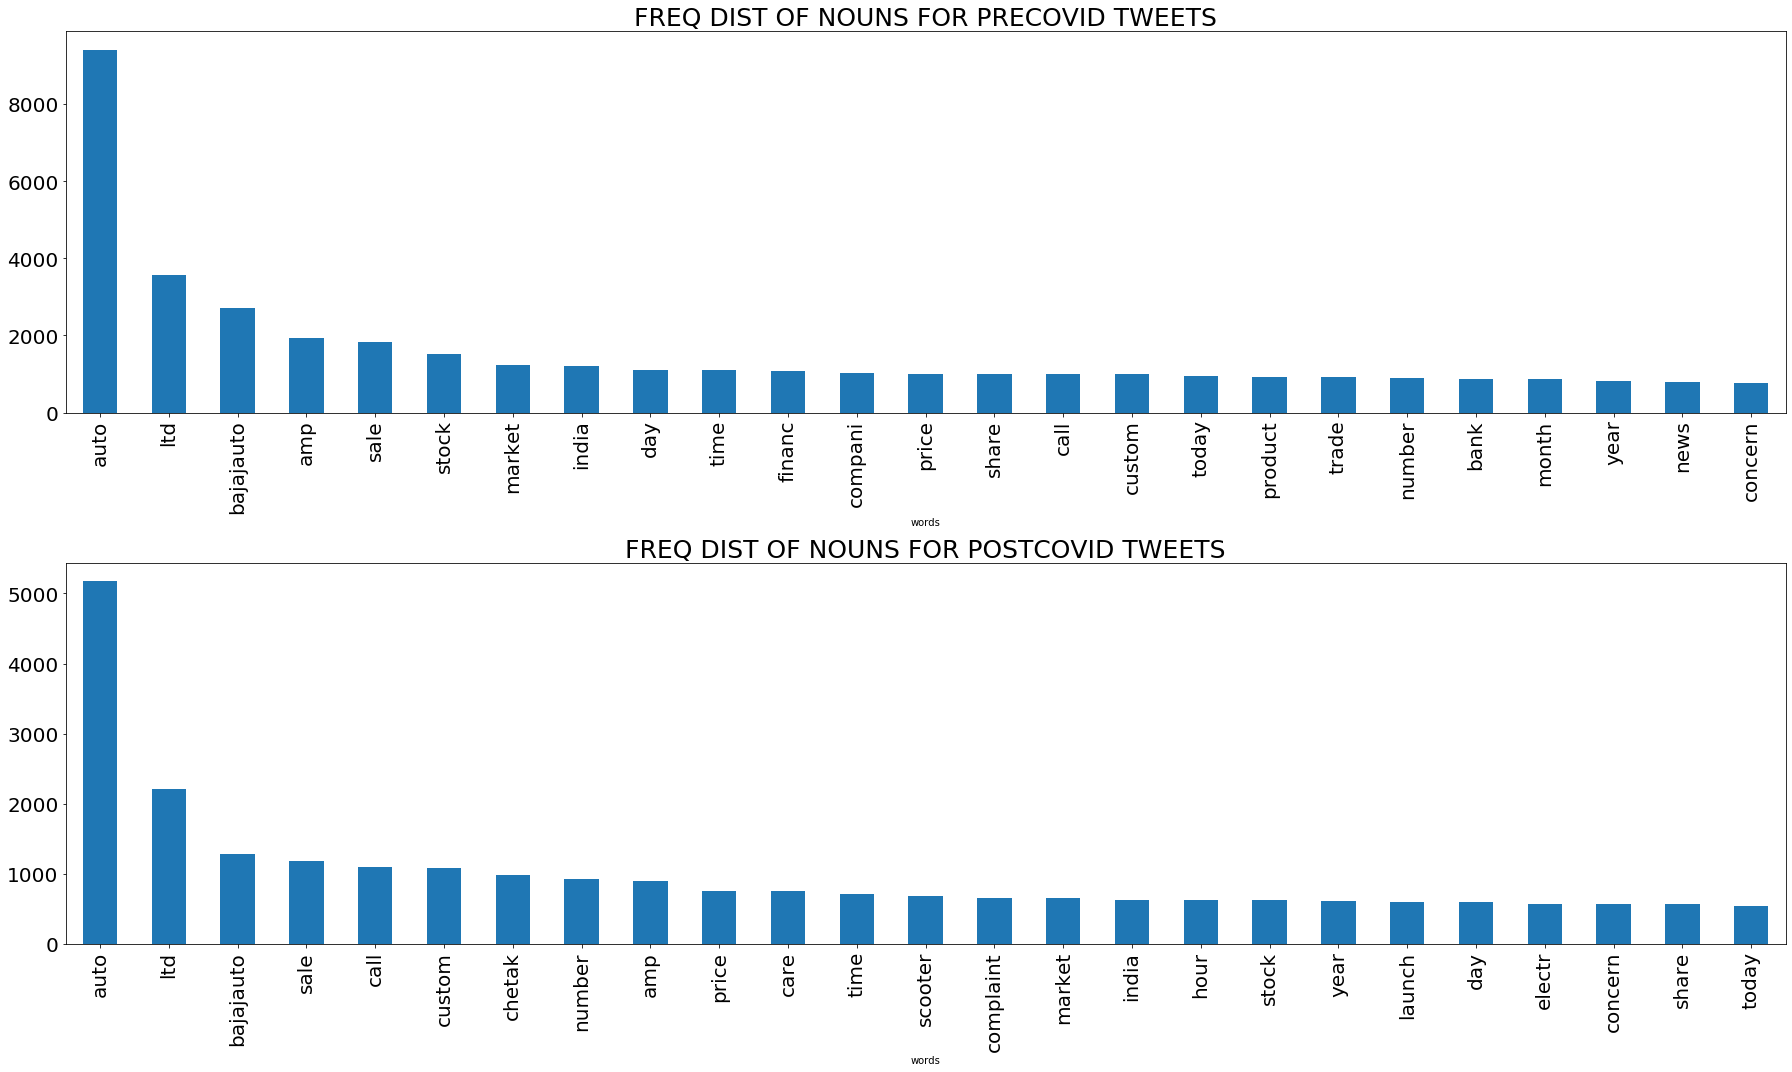

In [96]:
freqdists = [get_freqdist_pos(post_covid_tweets,"NN"),get_freqdist_pos(pre_covid_tweets,"NN")]
fig,axes = plt.subplots(2,1,figsize=(25,15))
for i in range(len(freqdists)):
    freqdists[i].head(25).plot.bar(x='words',y='freq',ax=axes[i])
    axes[i].set_title("FREQ DIST OF NOUNS FOR "+periods[i].upper()+" TWEETS",fontsize=25)
    #axes[i].set_xlabel('',fontsize=20)
    #axes[i].set_ylabel('Count',fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

In [97]:
neg_dist_tweets_pos = get_freqdist_pos(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]),"NN")
pos_dist_tweets_pos = get_freqdist_pos(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]),"NN")

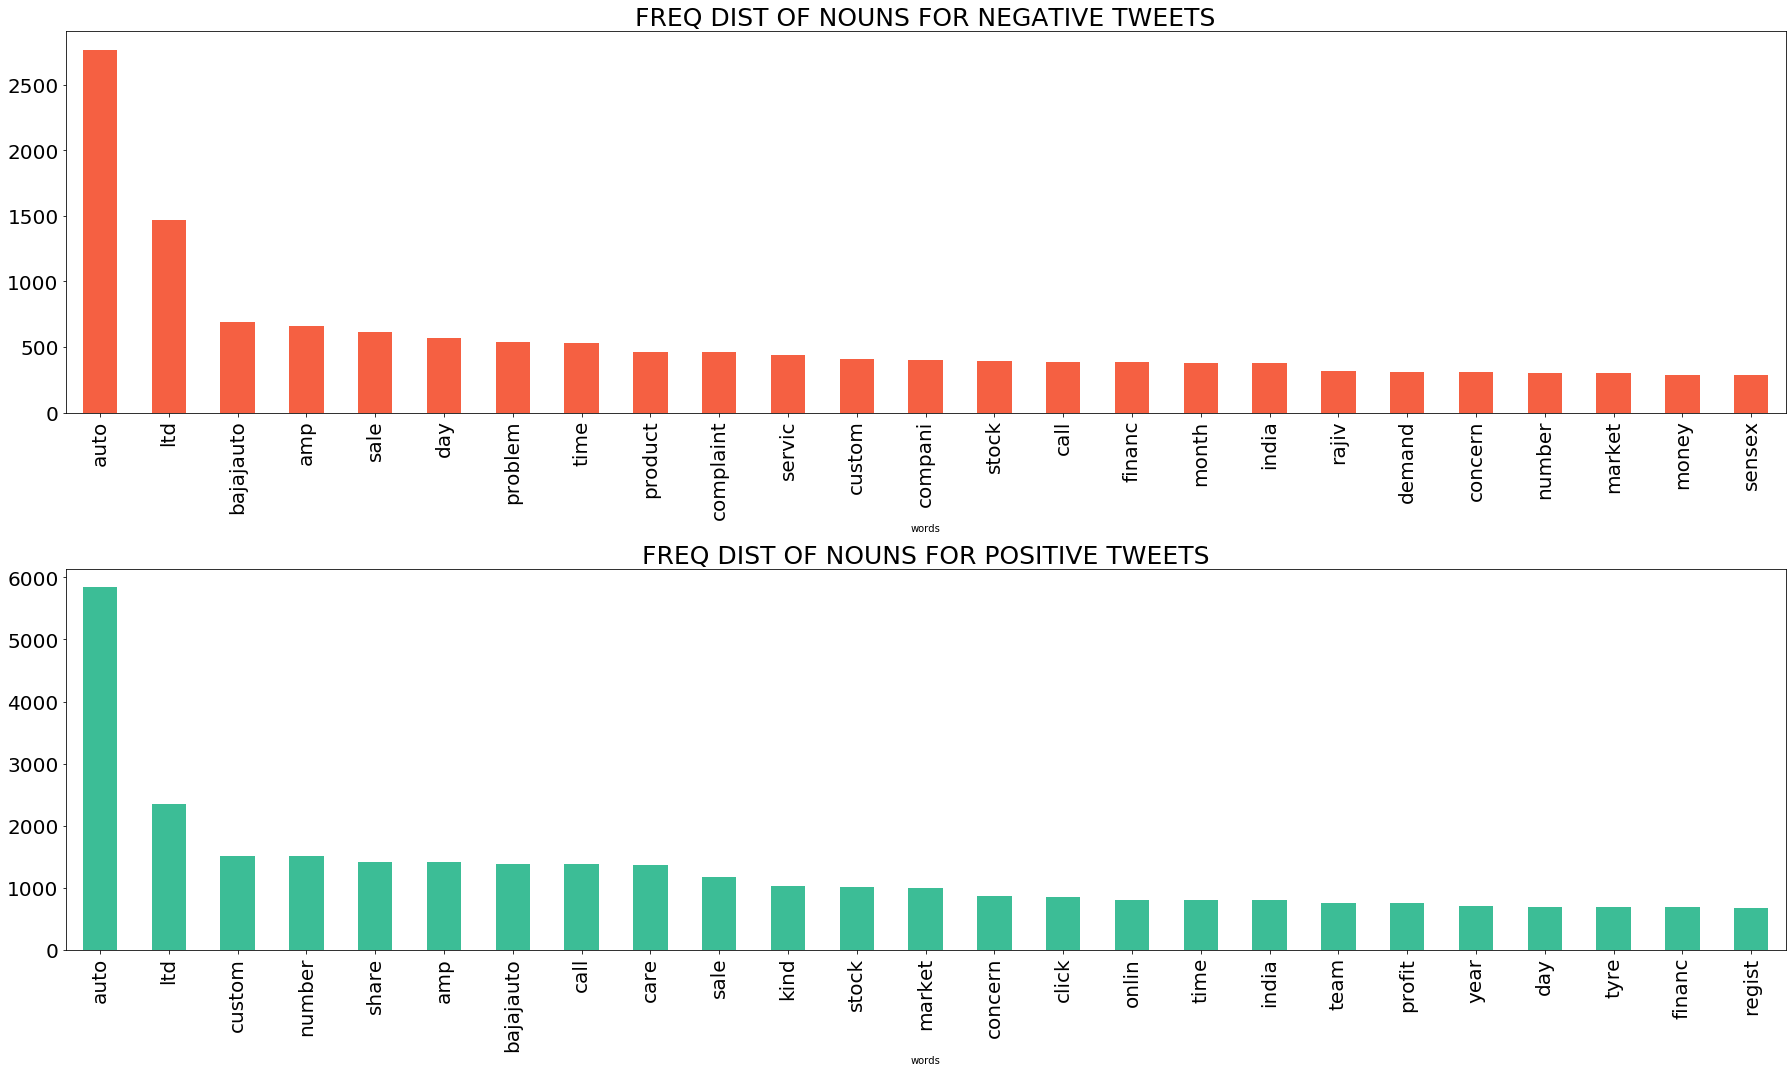

In [98]:
freqdists = [neg_dist_tweets_pos,pos_dist_tweets_pos]
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
fig,axes = plt.subplots(2,1,figsize=(25,15))
for i in range(len(freqdists)):
    freqdists[i].head(25).plot.bar(x='words',y='freq',ax=axes[i],color=colors[i])
    axes[i].set_title("FREQ DIST OF NOUNS FOR "+names[i]+" TWEETS",fontsize=25)
    #axes[i].set_xlabel('',fontsize=20)
    #axes[i].set_ylabel('Count',fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

In [99]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [100]:
tfidf_vect = TfidfVectorizer(stop_words=stop_updated)
X = tfidf_vect.fit_transform(all_tweets['clean_tweets'])
tfidf = pd.DataFrame(X.toarray(), columns=tfidf_vect.get_feature_names())
tfidf

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['auto', 'avenger', 'bajajauto', 'chetak', 'dominar', 'platina', 'pulasrns', 'street', 'wheeer'] not in stop_words.



,000,0000,00000009,0000007,000001,0000010317,00000494,00000620,00028860,00033786,...,zorkajhatkadheeres,zoya,zproduct,zscore,zsm,zuluk,zumba,zx6r,zydus,zyduswel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Below Codes not Required

In [104]:
import spacy
!python -m spacy download en_core_web_sm

ModuleNotFoundError: No module named 'spacy'

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint



import pickle

import pyLDAvis
import pyLDAvis.gensim

In [ ]:
nlp=spacy.load('en_core_web_sm',disable=['praser','ner'])
def lemmatization(clean_tweets,allowed_postags=['NOUN','ADJ']):
    output=[]
    for sent in clean_tweets:
        doc=nlp(sent)
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return output

In [ ]:
text_list=pre_covid_tweets[('clean_tweets')].tolist()
print(text_list[1])
tokenized_tweets=lemmatization(text_list)
print(tokenized_tweets[1])

In [ ]:
dictionary=corpora.Dictionary(tokenized_tweets)
doc_term_matrix=[dictionary.doc2bow(clean_tweets) for clean_tweets in tokenized_tweets]

In [ ]:
LDA=gensim.models.ldamodel.LdaModel
lda_model=LDA(corpus=doc_term_matrix,id2word=dictionary,num_topics=10,random_state=100,
              chunksize=1000,passes=50,iterations=100)


In [ ]:
lda_model.print_topics()

In [ ]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,doc_term_matrix,dictionary)
vis

In [ ]:
text_list=post_covid_tweets[('clean_tweets')].tolist()
print(text_list[1])
tokenized_tweets=lemmatization(text_list)
print(tokenized_tweets[1])

In [ ]:
dictionary=corpora.Dictionary(tokenized_tweets)
doc_term_matrix=[dictionary.doc2bow(clean_tweets) for clean_tweets in tokenized_tweets]

In [ ]:
LDA=gensim.models.ldamodel.LdaModel
lda_model=LDA(corpus=doc_term_matrix,id2word=dictionary,num_topics=10,random_state=100,
              chunksize=1000,passes=50,iterations=100)


In [ ]:
lda_model.print_topics()

In [ ]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,doc_term_matrix,dictionary)
vis

In [ ]:
print('\nPerplexity:',lda_model.log_perplexity(doc_term_matrix, total_docs=10000))

from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda=CoherenceModel(model=lda_model,texts=tokenized_tweets,dictionary=dictionary,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)
